# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.ticker as ticker

# Dataset Visualizer Class

In [2]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

class DataPartition(Dataset):
    def __init__(self, data_partition):
        super().__init__()
        self.component_columns = component_columns
        self.event_columns = event_columns
        self.data_partition = data_partition
        self.components, self.events = self.load_data(data_partition)
        # VEDD KI A FLAGET IS (MERT TOK FELESLEGES)
        # HOZD AZ ADATOKAT HELYESS int/float pontossagra
        # one-hot encoding --> de nem trivialis
        self.filter_invalid_rows_from_events()
        self.add_duration_to_events()
        
    def load_data(self, data_partition):
        if data_partition == "A" or data_partition == "B":
            data_path = f'/home/appuser/data/train/SCLDDoS2024_Set{data_partition}'
        elif data_partition == "C":
            data_path = '/home/appuser/data/test/SCLDDoS2024_SetC'
        elif data_partition == "D":
            data_path = '/home/appuser/data/gen/SCLDDoS2024_SetD'
        else:
            raise ValueError("Invalid data partition, the valid options are: A, B, C, D")
        
        components = pd.read_csv(f'{data_path}_components.csv')
        events = pd.read_csv(f'{data_path}_events.csv')
        
        components.columns = self.component_columns
        events.columns = self.event_columns

        return components, events

    # remove the rows that has the End Time set to 0 as we don't know what that means
    def filter_invalid_rows_from_events(self):
        self.events = self.events[self.events['End time'].astype(str) != '0']

    # add a new column to the events dataframe that contains the duration of the event
    def add_duration_to_events(self):
        self.events['Start time'] = pd.to_datetime(self.events['Start time'])
        self.events['End time'] = pd.to_datetime(self.events['End time'])
        self.events['Duration'] = (self.events['End time'] - self.events['Start time']).dt.total_seconds().astype(int)
        
    def get_hist_bins_by_field(self, field):
        if field == "Duration":
            return np.arange(0, 305, 5), 10000
        elif field == 'Detect count':
            return np.arange(0, 51, 1), 50000
        elif field == "Avg source IP count":
            return np.arange(0, 360, 10), 50000
        elif field == "Avg packet len":
            return np.arange(1000, 1510, 10), 10000
        elif field == "Data speed":
            s = self.events[field]
            return np.arange(0, 1015, 15), 10000
            max_val = self.events[field].max()
            mean = self.events[field].mean()
            min_val = self.events[field].min()
            s = 0
        else:
            raise ValueError("You provided an invalid field option")

    # How much of the datatset is DDos attack, normal traffic and suspicious traffic
    def create_dist_pie_chart_for_events(self, save=False):
        event_types = self.events['Type'].value_counts()
        percentages = event_types / event_types.sum() * 100  # Calculate percentages
        labels = [f"{label} ({percent:.1f}%)" for label, percent in zip(event_types.index, percentages)]  # Add percentages to labels
        
        event_types.plot.pie(labels=labels, autopct='', startangle=0, fontsize=12)  # Remove autopct
        plt.ylabel('')
        plt.title(f'Event type distribution for data partition {self.data_partition}', fontsize=16)
        if save:
            plt.savefig(f'plots/event_distribution_{self.data_partition}.png',bbox_inches='tight')
        plt.show()
        
    # Create a histogram based on the 'field' column
    def create_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        plt.figure(figsize=(27, 9))
        bins, ymax = self.get_hist_bins_by_field(field)

        ax = sns.histplot(
            data=data, 
            x=field,
            hue='Type',  
            bins=bins, 
            multiple="stack",  
            alpha=0.8,
            hue_order=["DDoS attack", "Suspicious traffic", "Normal traffic"],
            palette={
                "DDoS attack": "#28a745",
                "Suspicious traffic": "#dc3545",
                "Normal traffic": "#007bff"
            },
            legend=True,
            edgecolor='none',
            element='bars',
            shrink=0.9,
        )

        plt.gca().set_facecolor('lavender')
        plt.title(f'Event {field} histogram for data partition {self.data_partition}', fontsize=20)
        plt.xlabel(f'{field}', fontsize=18)
        plt.ylabel('Number of Occurrences', fontsize=18)
        plt.ylim(0, ymax)
        xmax = max(bins)
        xmin = 1000 if field == "Avg packet len" else 0
        plt.xlim(xmin, xmax)

        # Format y-axis labels to show 'k' for thousands
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

        # Increase font size for axis labels and ticks
        plt.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)
        
        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the columns)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1) 
        
        if save:
            plt.savefig(f'plots/event_{field}_histogram_{self.data_partition}.png', bbox_inches='tight')
        plt.show()
        
    # Create a binwise normalised histogram based on the 'field' column
    def create_normalized_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        bins, _ = self.get_hist_bins_by_field(field)

        # Assign each data point to a bin
        data['bin'] = pd.cut(data[field], bins=bins, include_lowest=True)
    
        # Compute counts per bin per type
        counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)

        # Normalize each bin so columns sum to 1
        normalized_counts = counts.div(counts.sum(axis=1), axis=0).fillna(0)        

        # Define categories
        categories = ["DDoS attack", "Suspicious traffic", "Normal traffic"]
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(normalized_counts)) 
        for cat, color in zip(categories, colors):
            sns.barplot(
                x=bins[1:], 
                y=normalized_counts[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += normalized_counts[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Event {field} normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel(f'{field}', fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_{field}_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()
        
    def create_normalized_histogram_for_attack_code(self,save=False):
        data = self.events.copy(deep=True)
        unique_attack_types = set(code.strip() for codes in data["Attack code"] for code in codes.split(","))
        unique_attack_types = sorted(unique_attack_types)  # Sorting for consistency
        
        label_per_ptype = np.zeros((len(unique_attack_types), 3))
        
        for index, row in data.iterrows():
            if row["Type"] == "DDoS attack":
                idx = 0
            elif row["Type"] == "Suspicious traffic":
                idx = 1
            else:
                idx = 2
            attack_codes = [code.strip() for code in row["Attack code"].split(",")]
            for attack_code in attack_codes:
                s = unique_attack_types.index(attack_code)
                label_per_ptype[unique_attack_types.index(attack_code), idx] += 1
        label_per_ptype_normalized = label_per_ptype / label_per_ptype.sum(axis=1, keepdims=True)
        
        df_normalized = pd.DataFrame(label_per_ptype_normalized, columns=["DDoS attack", "Suspicious traffic", "Normal traffic"], index=unique_attack_types)
                
        # Define categories
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ##ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(df_normalized)) 
        for cat, color in zip(df_normalized.columns, colors):
            sns.barplot(
                x=df_normalized.index, 
                y=df_normalized[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += df_normalized[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Attack code normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel("Attack code", fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Rotate the x-axis labels for readability
        plt.xticks(rotation=45, ha="right", fontsize=12)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_attack_code_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()

# Visualize features and distibutions

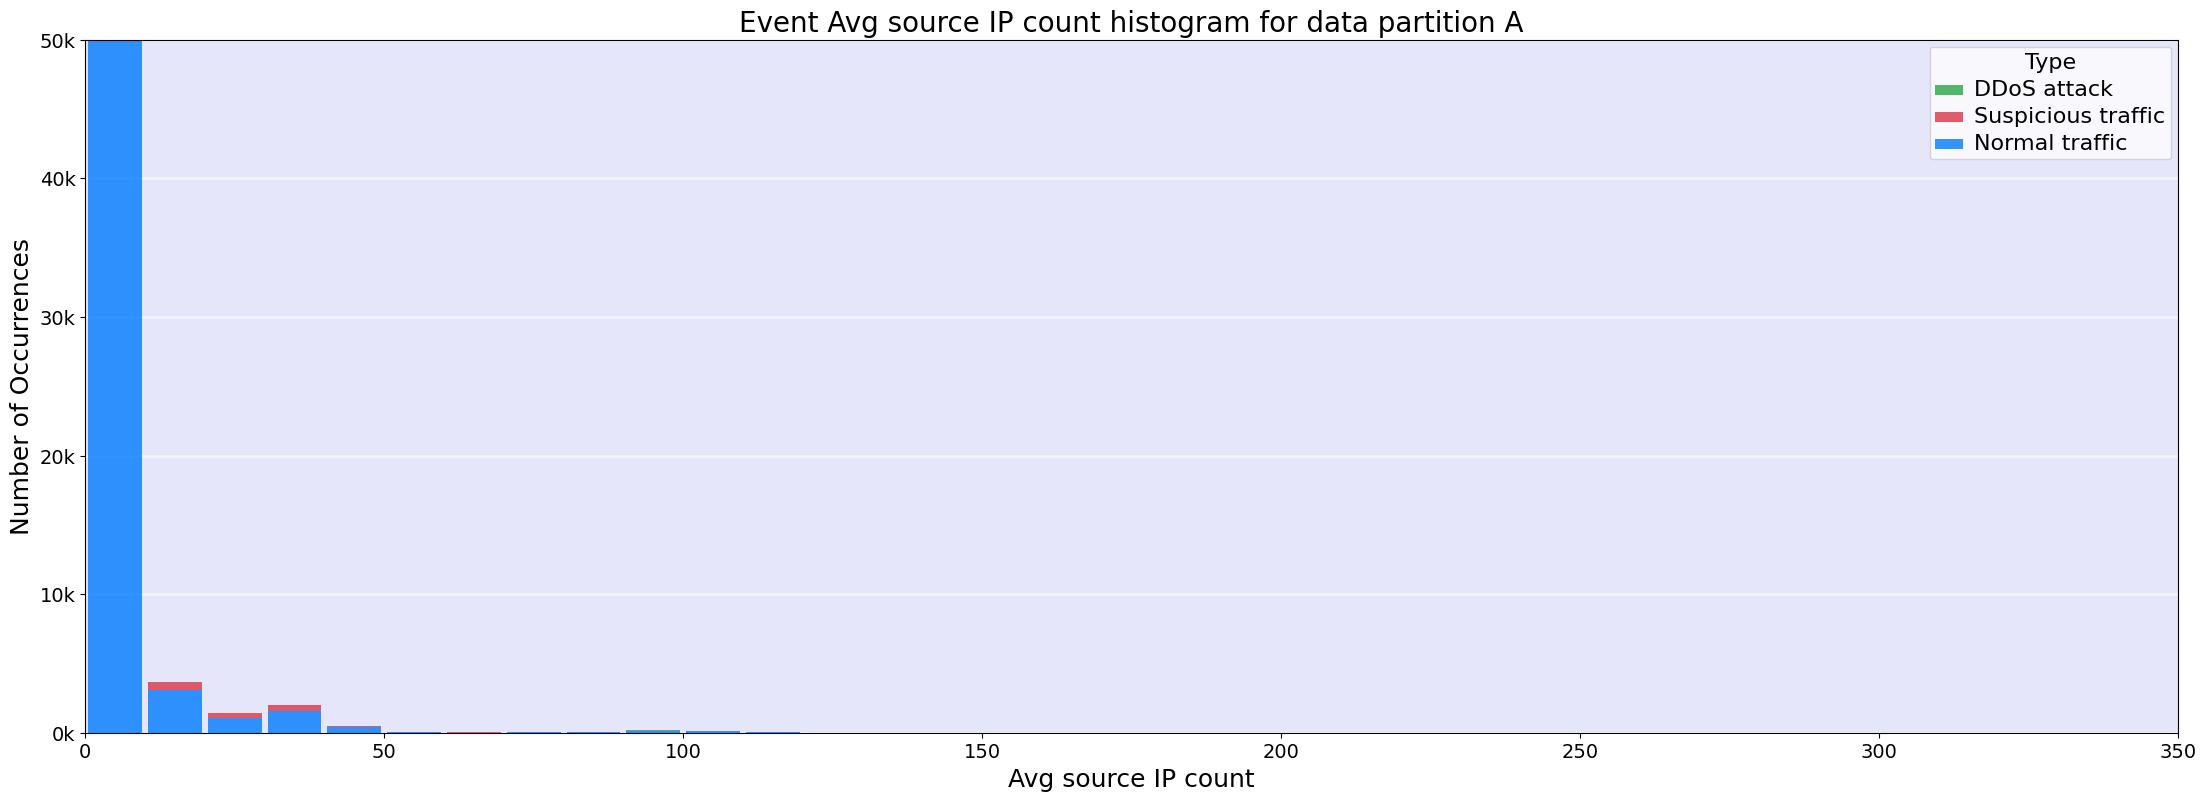

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


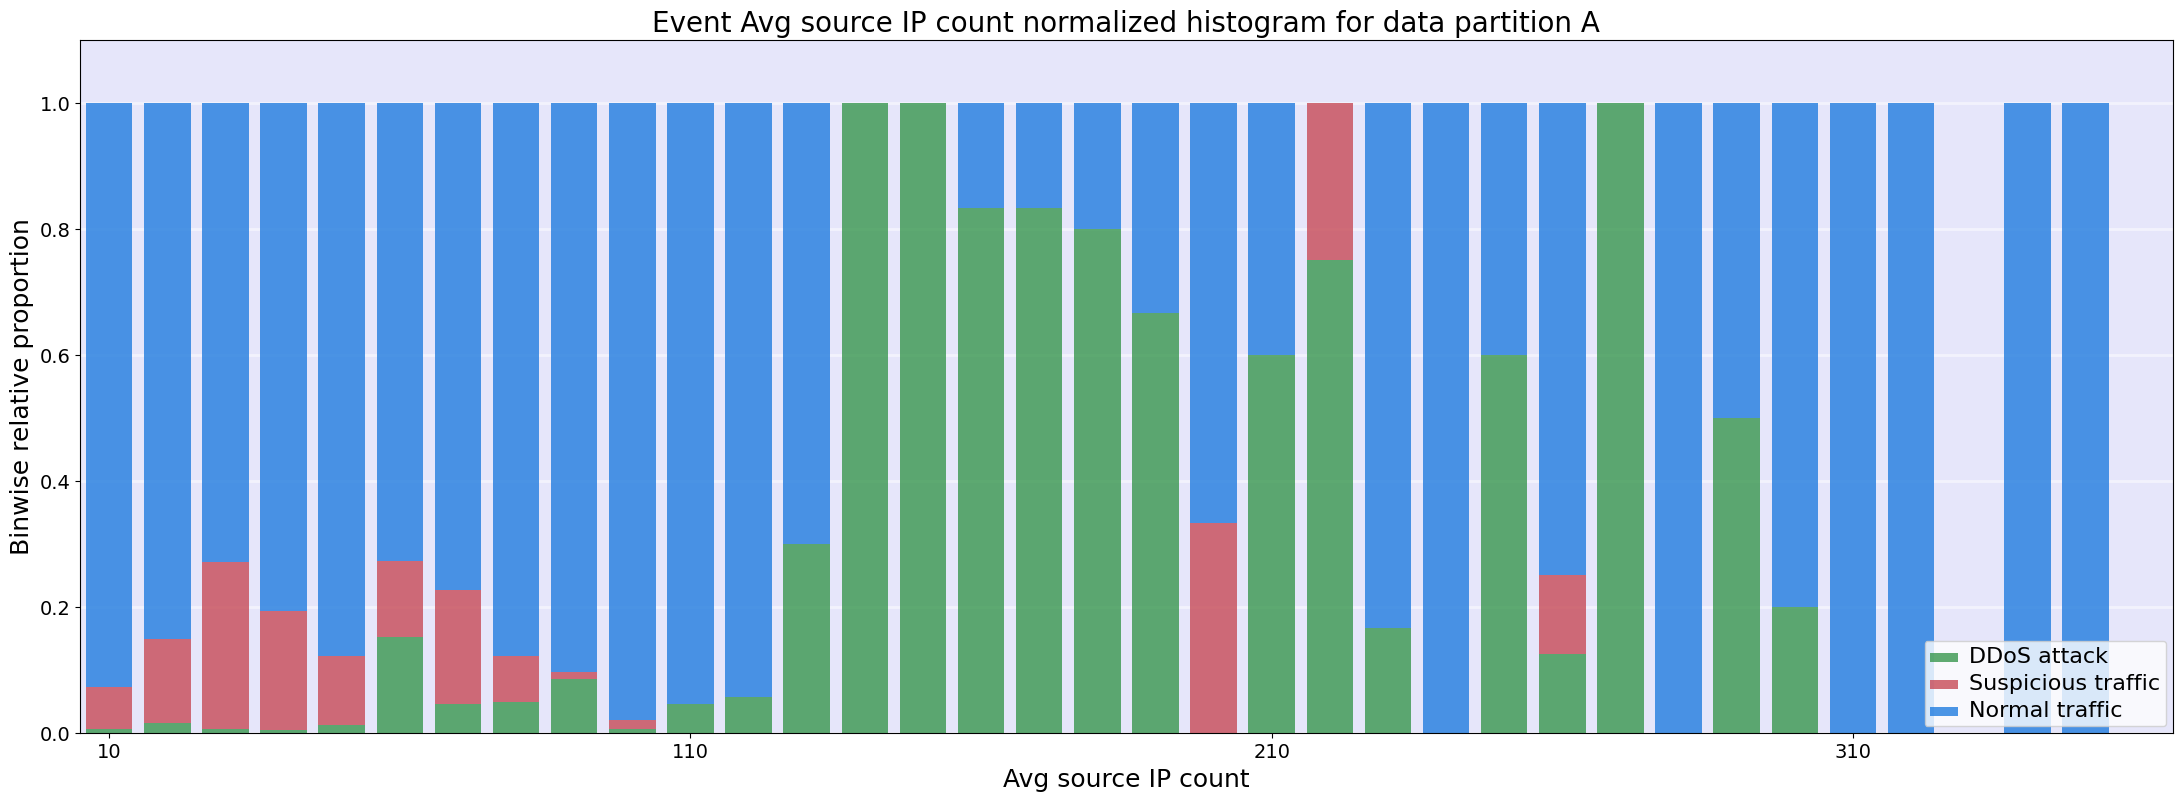

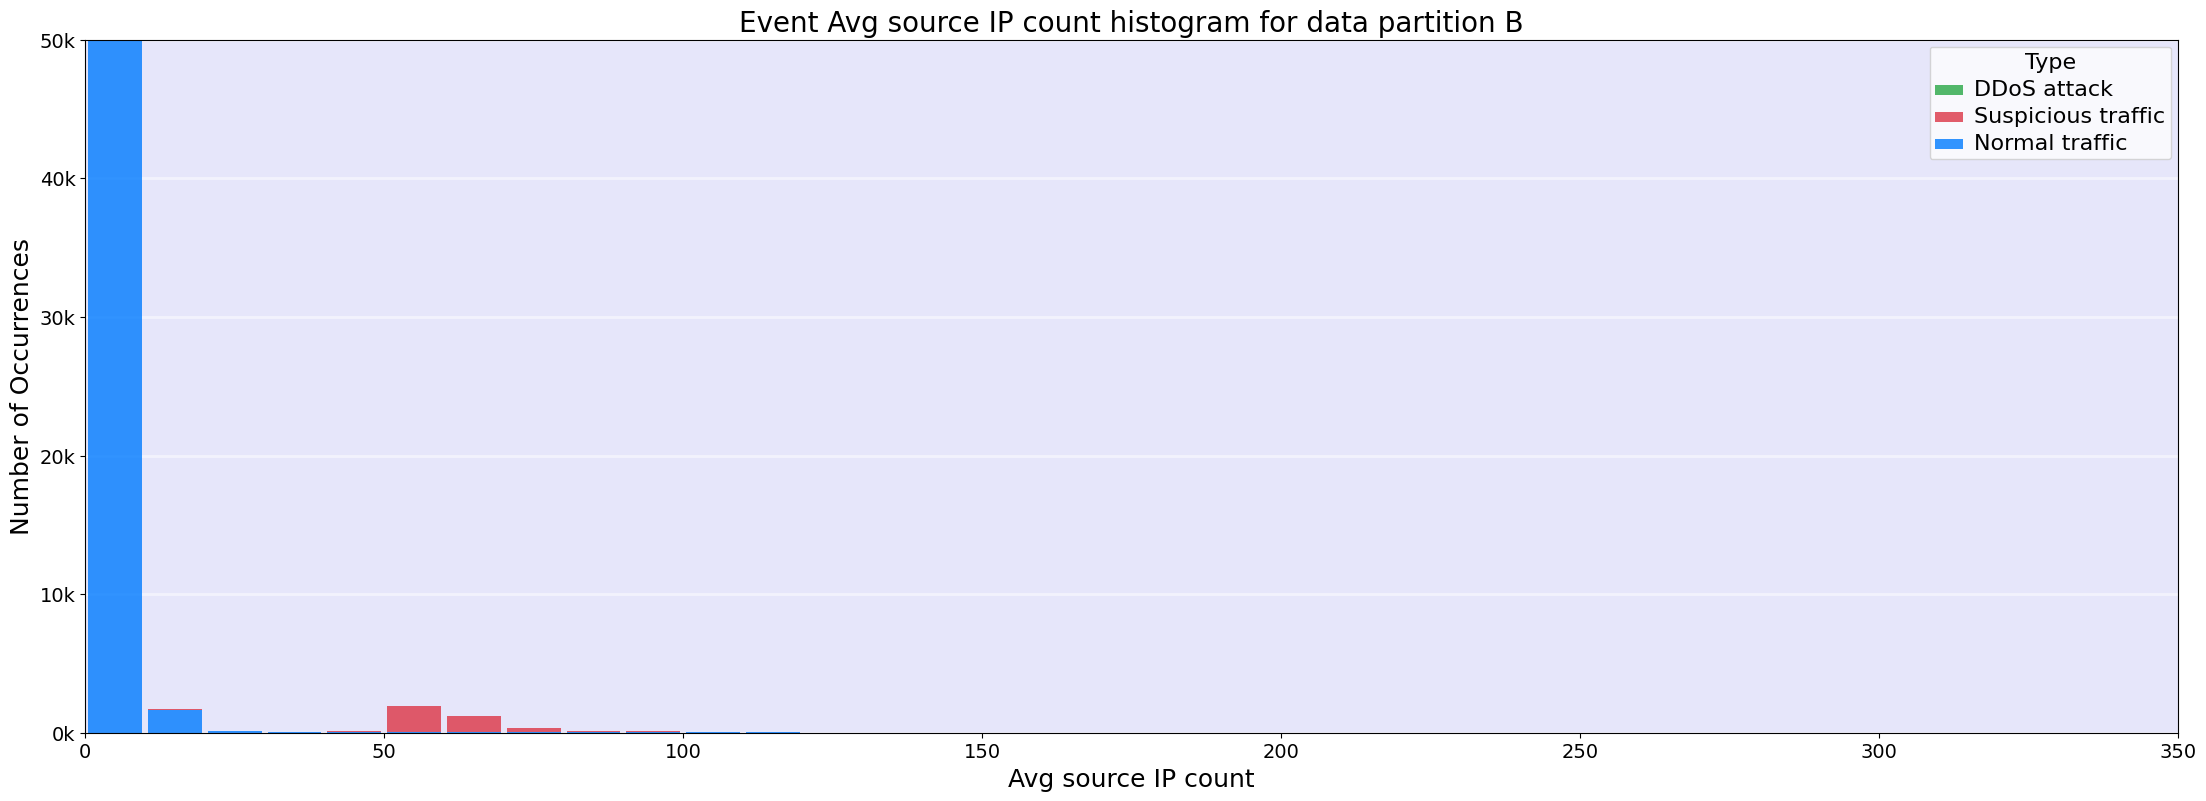

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


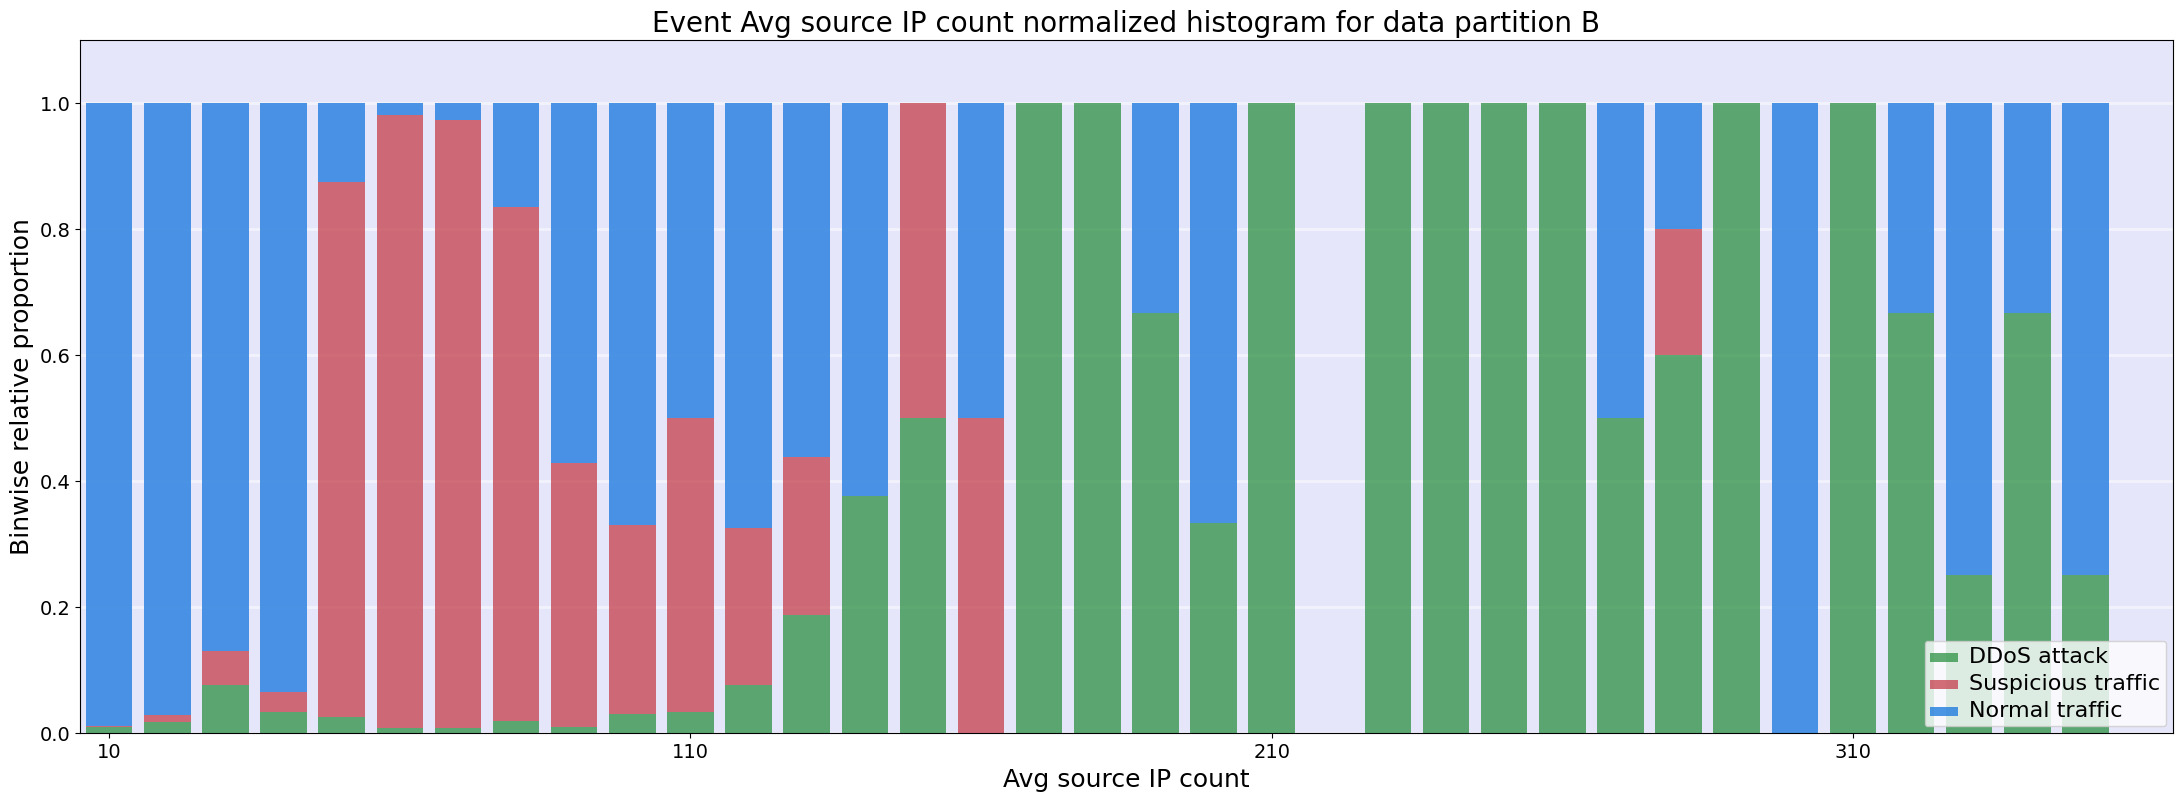

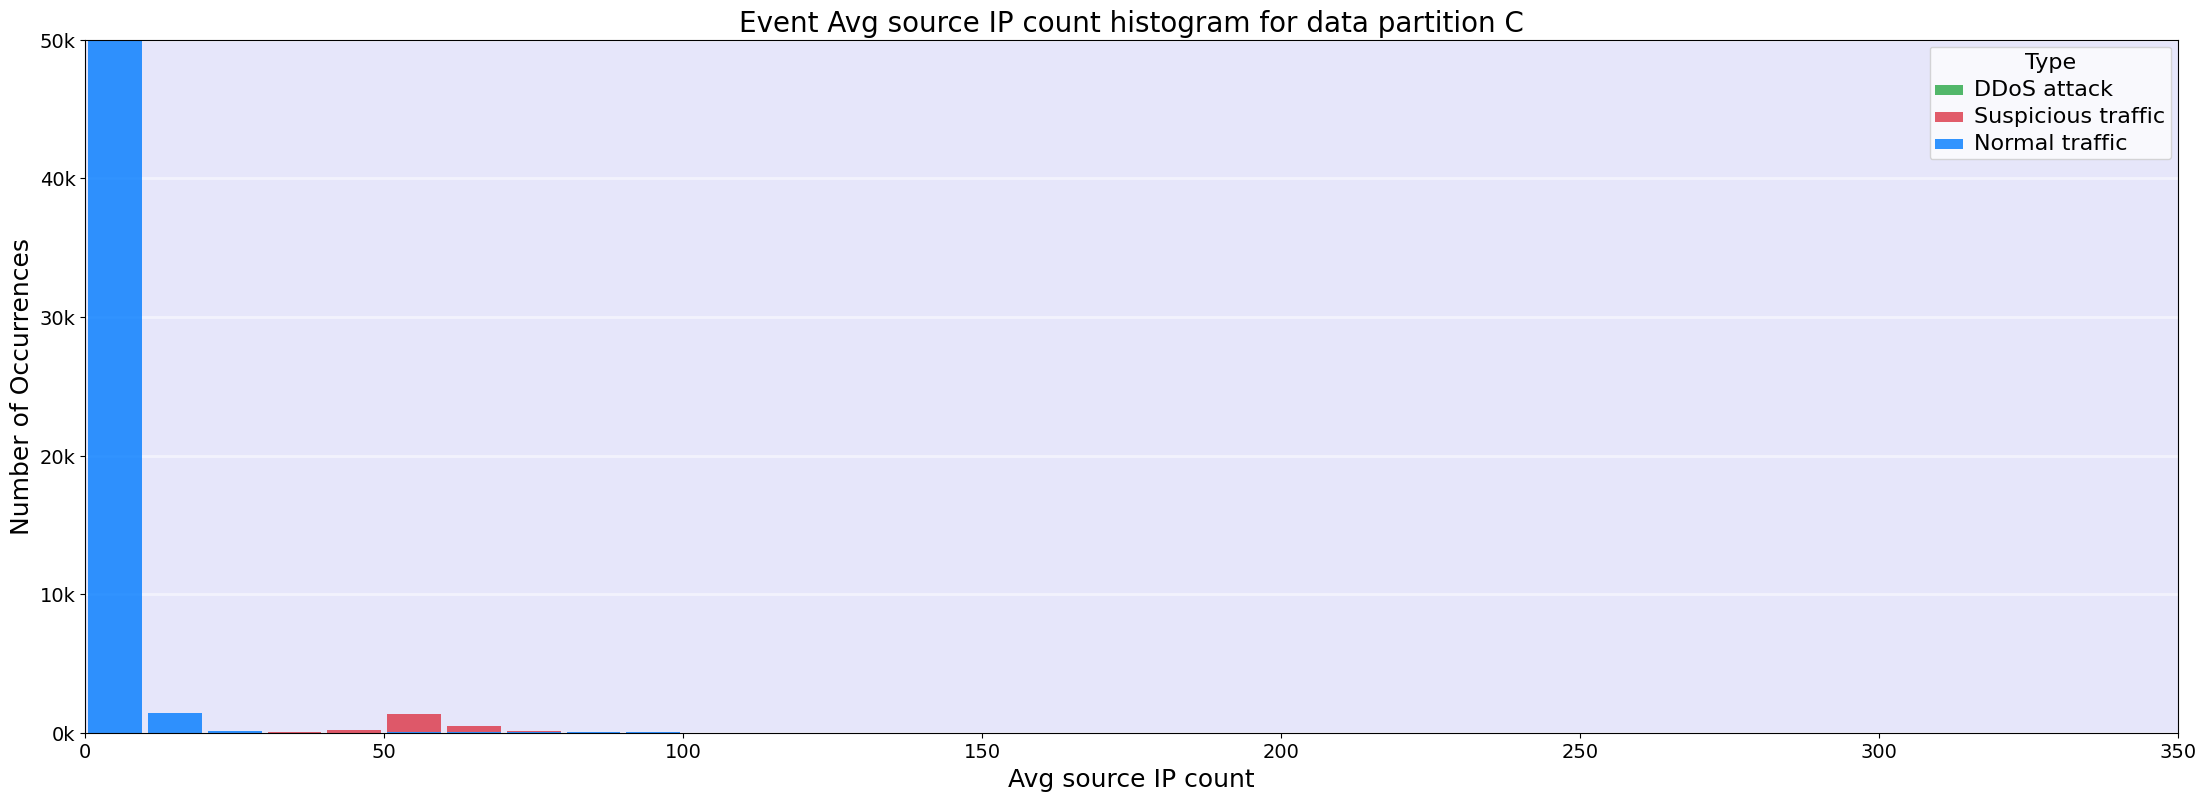

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


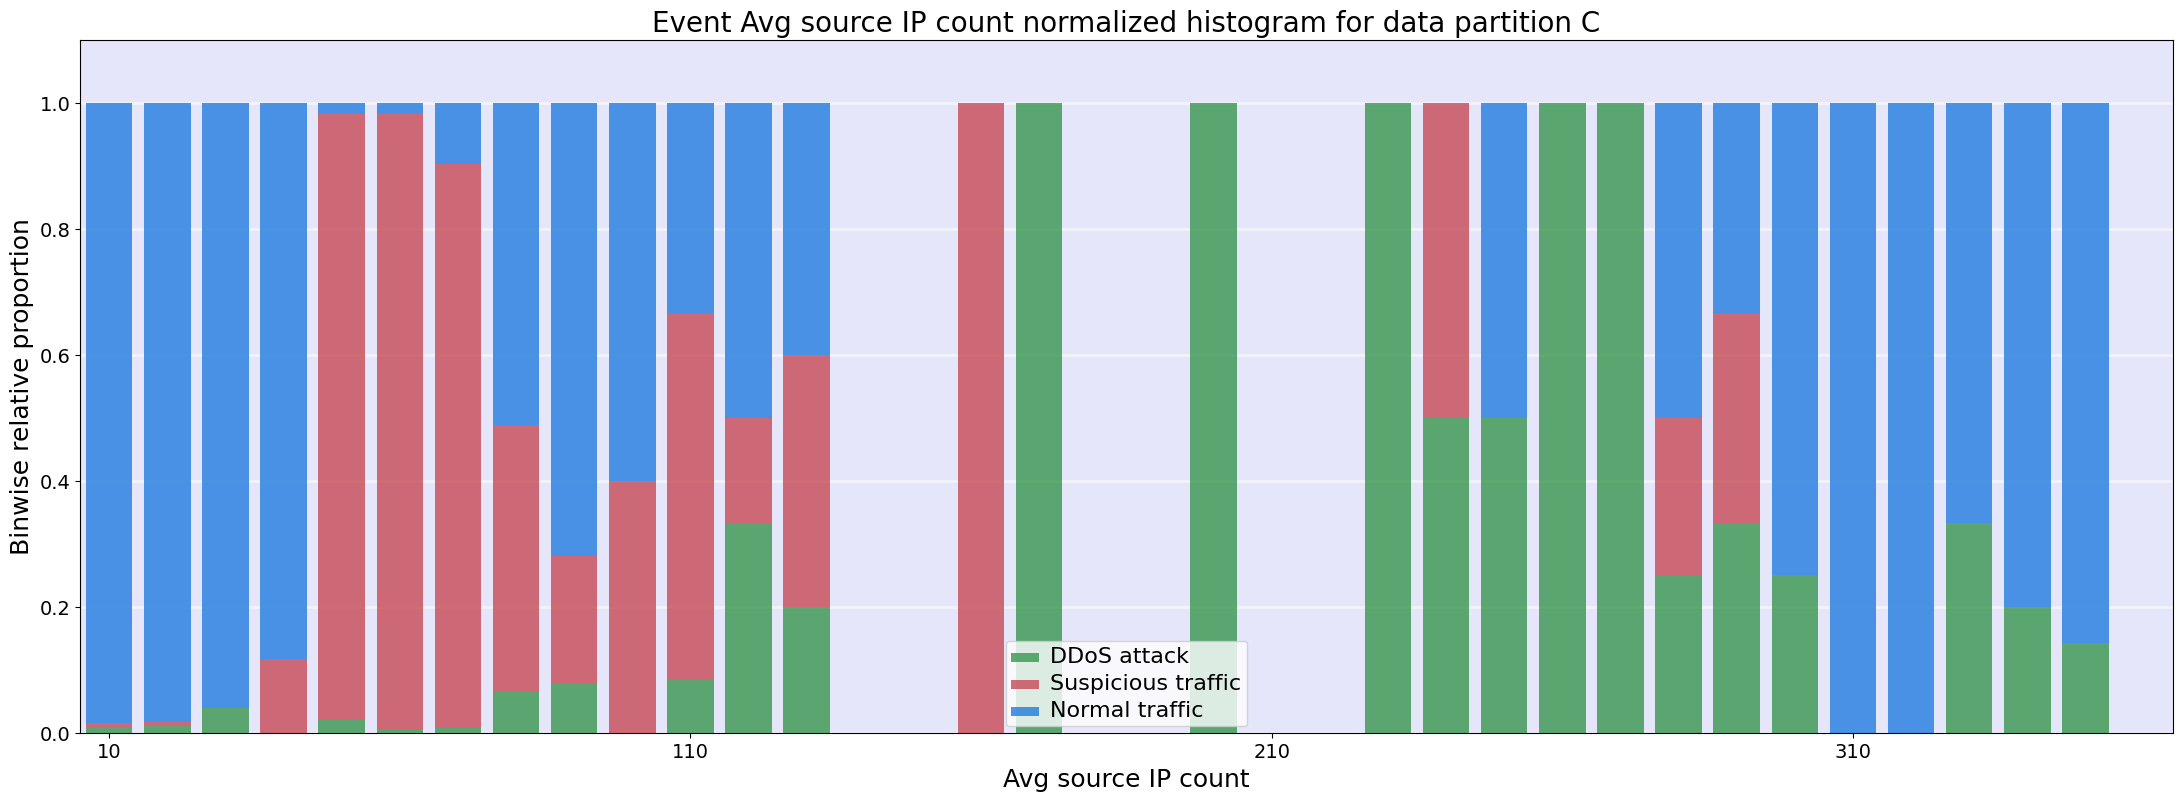

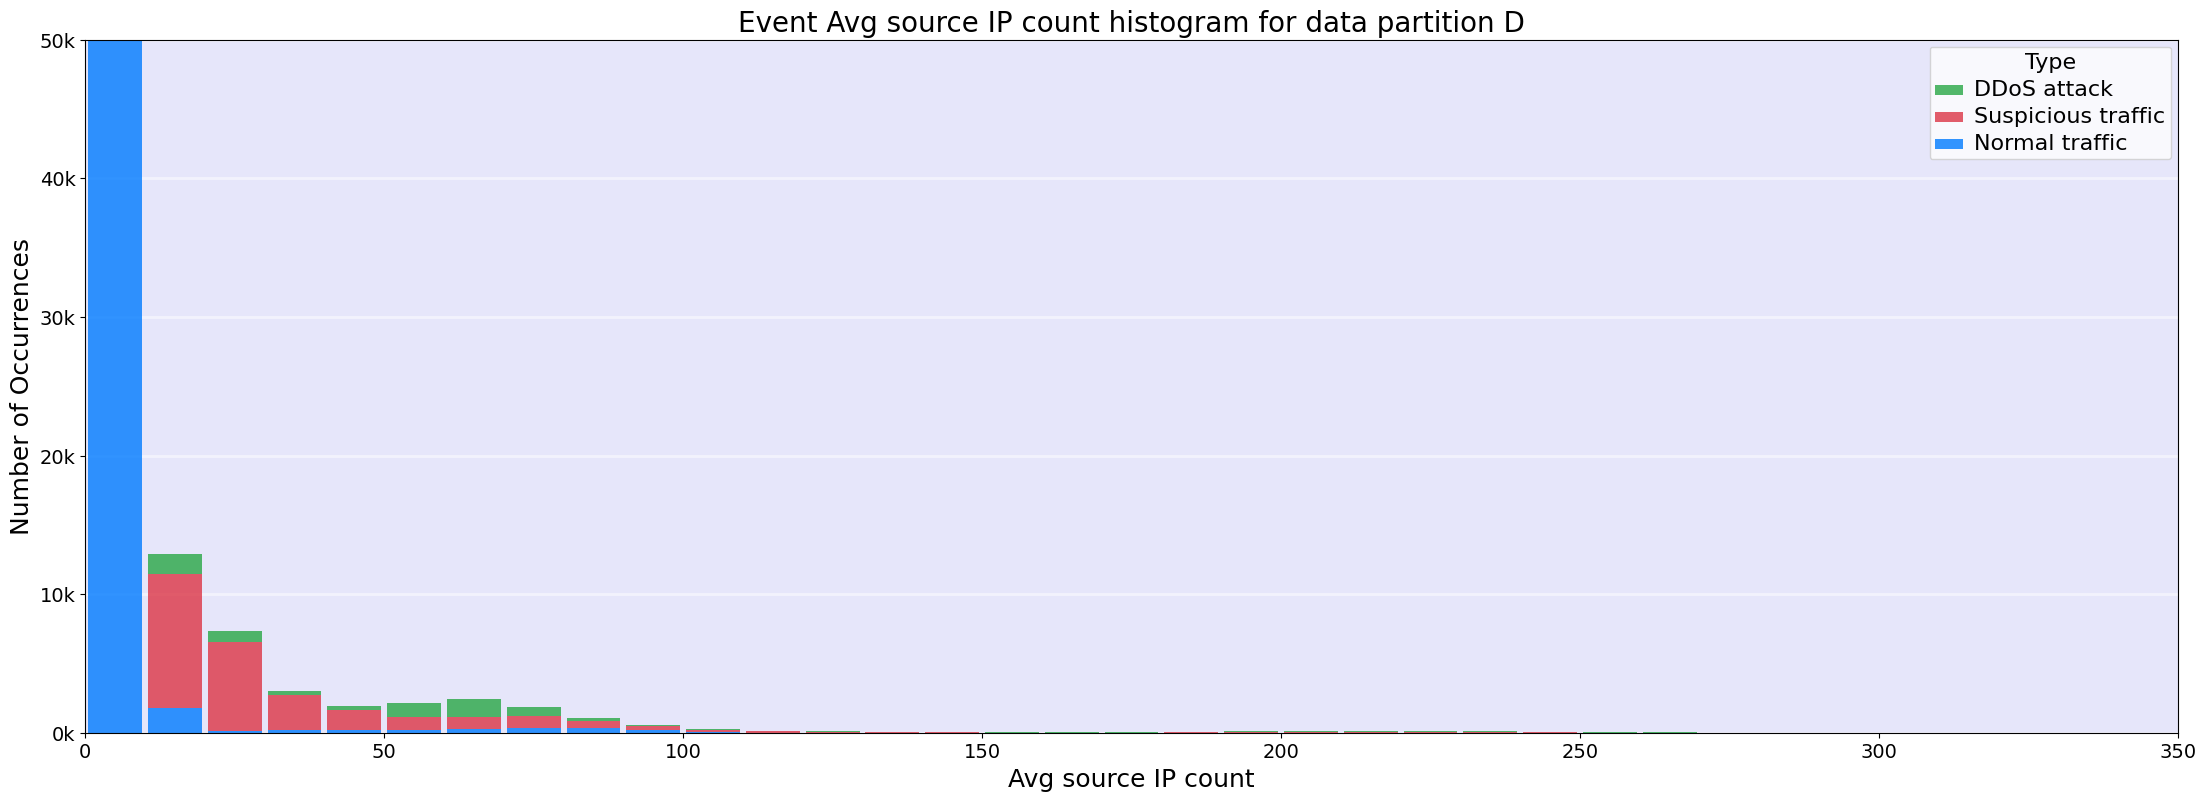

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


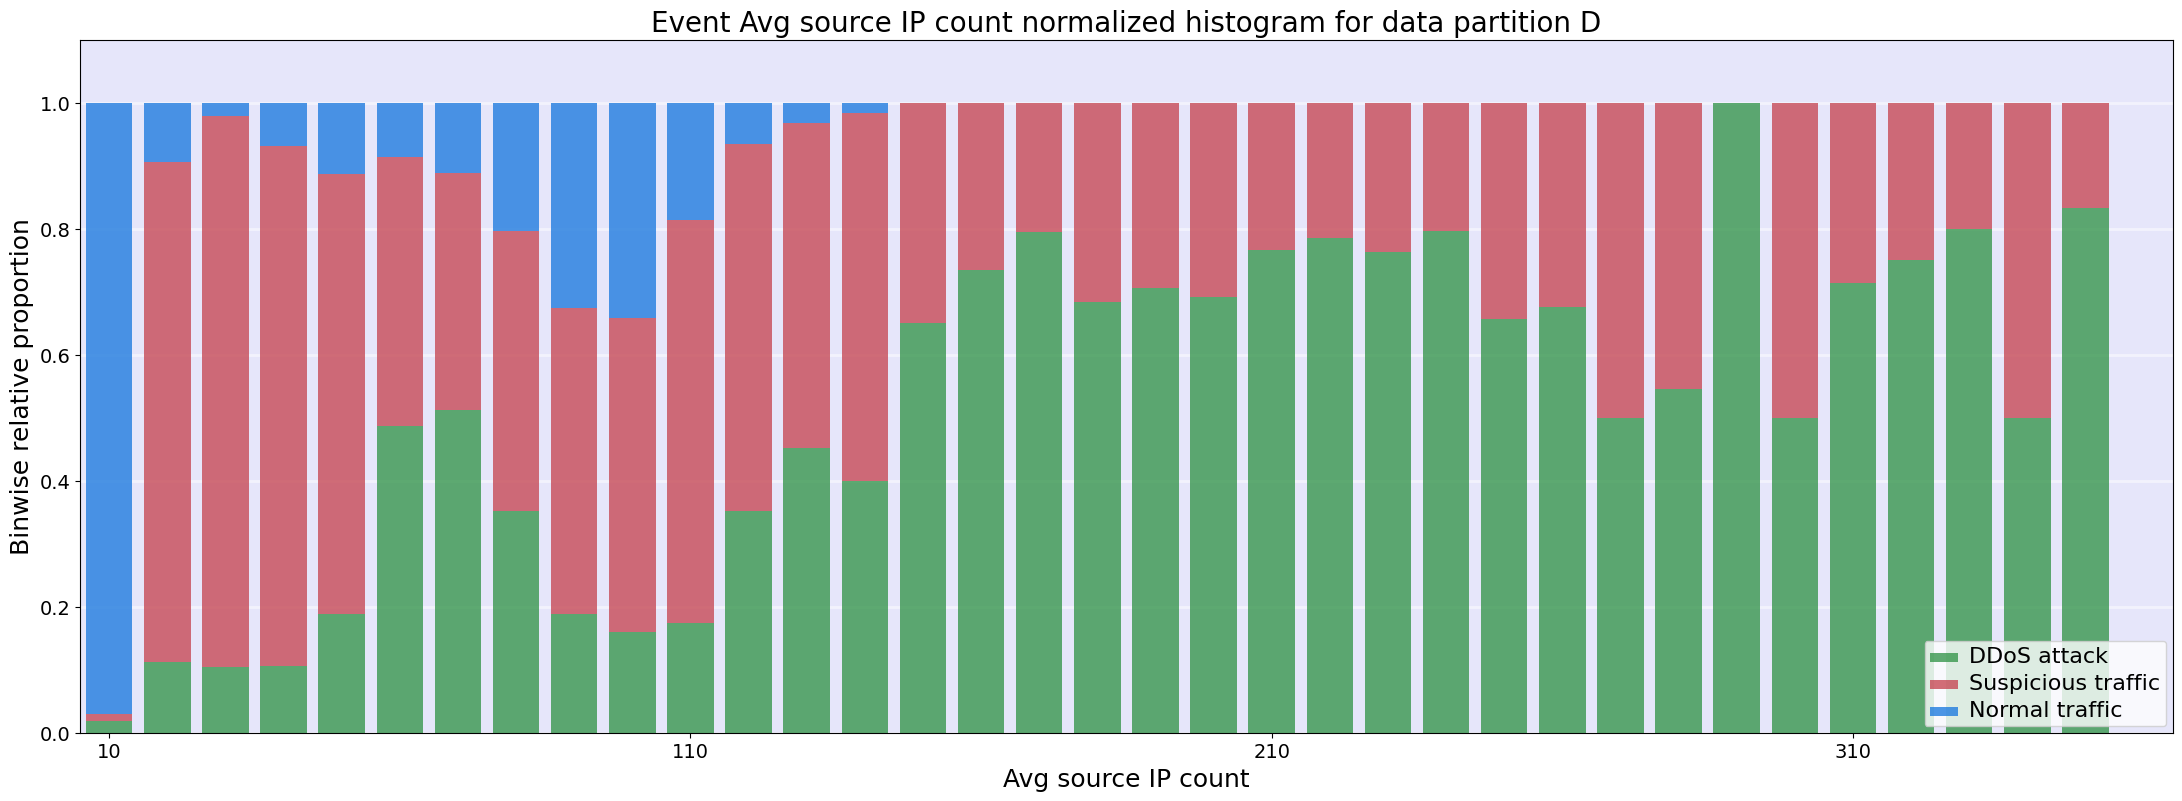

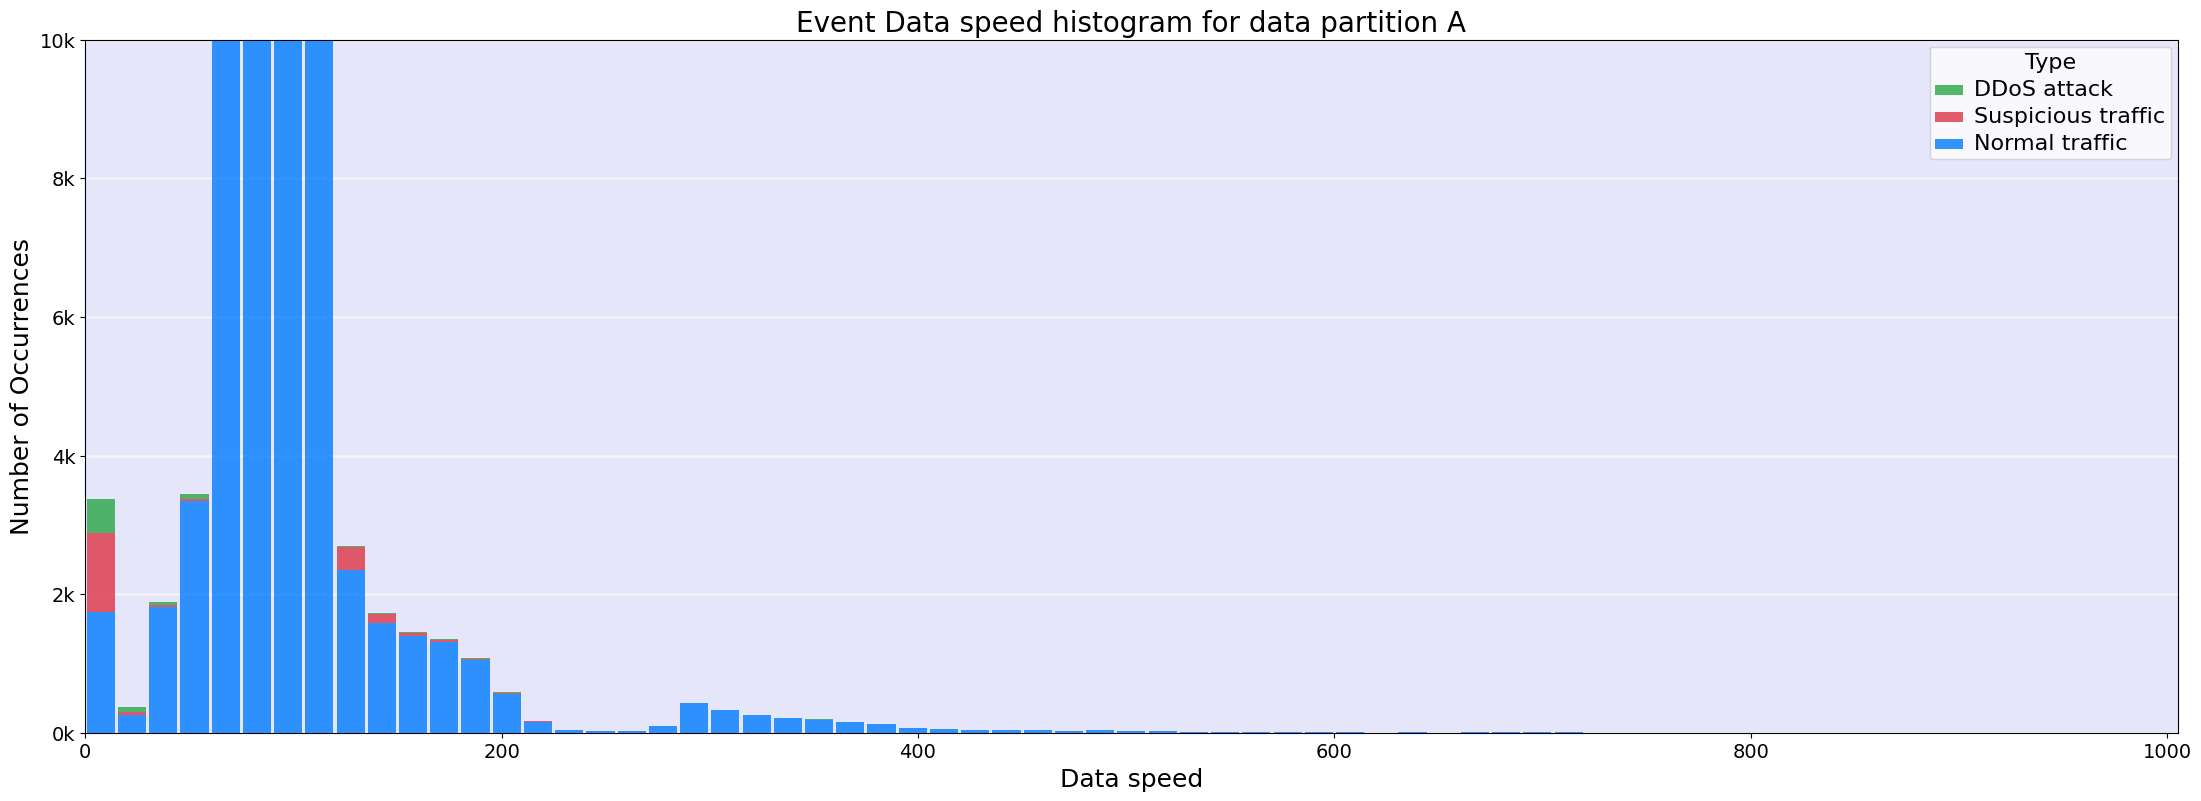

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


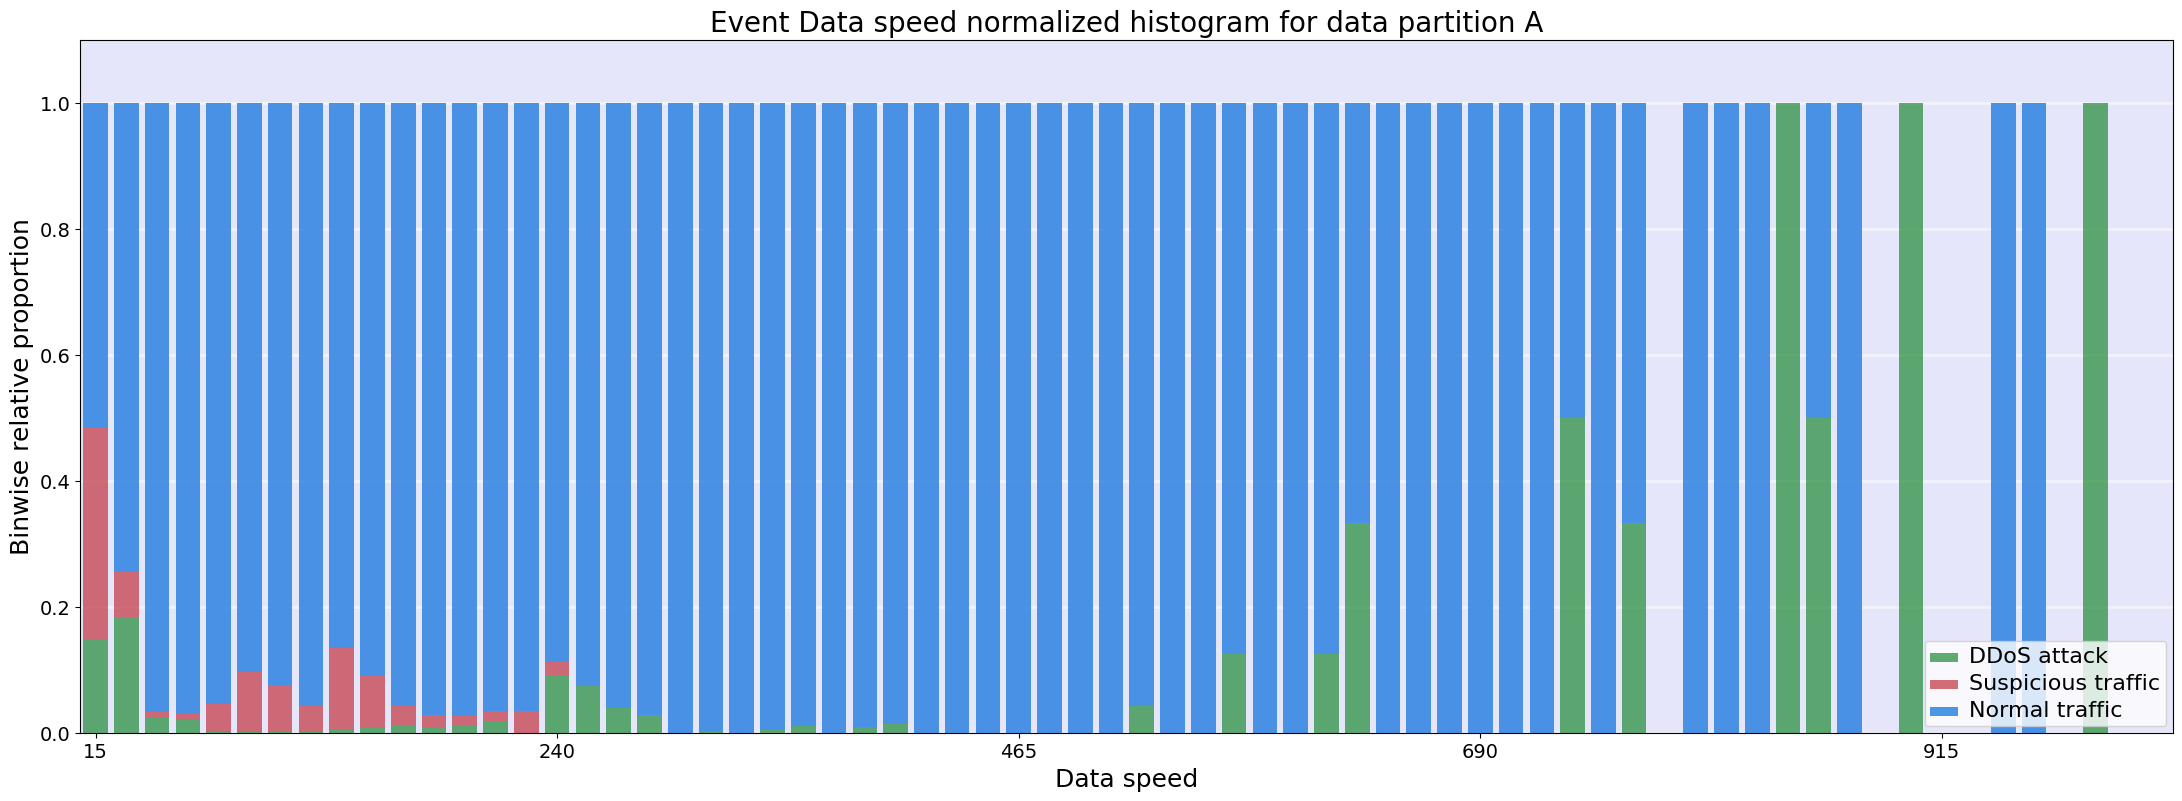

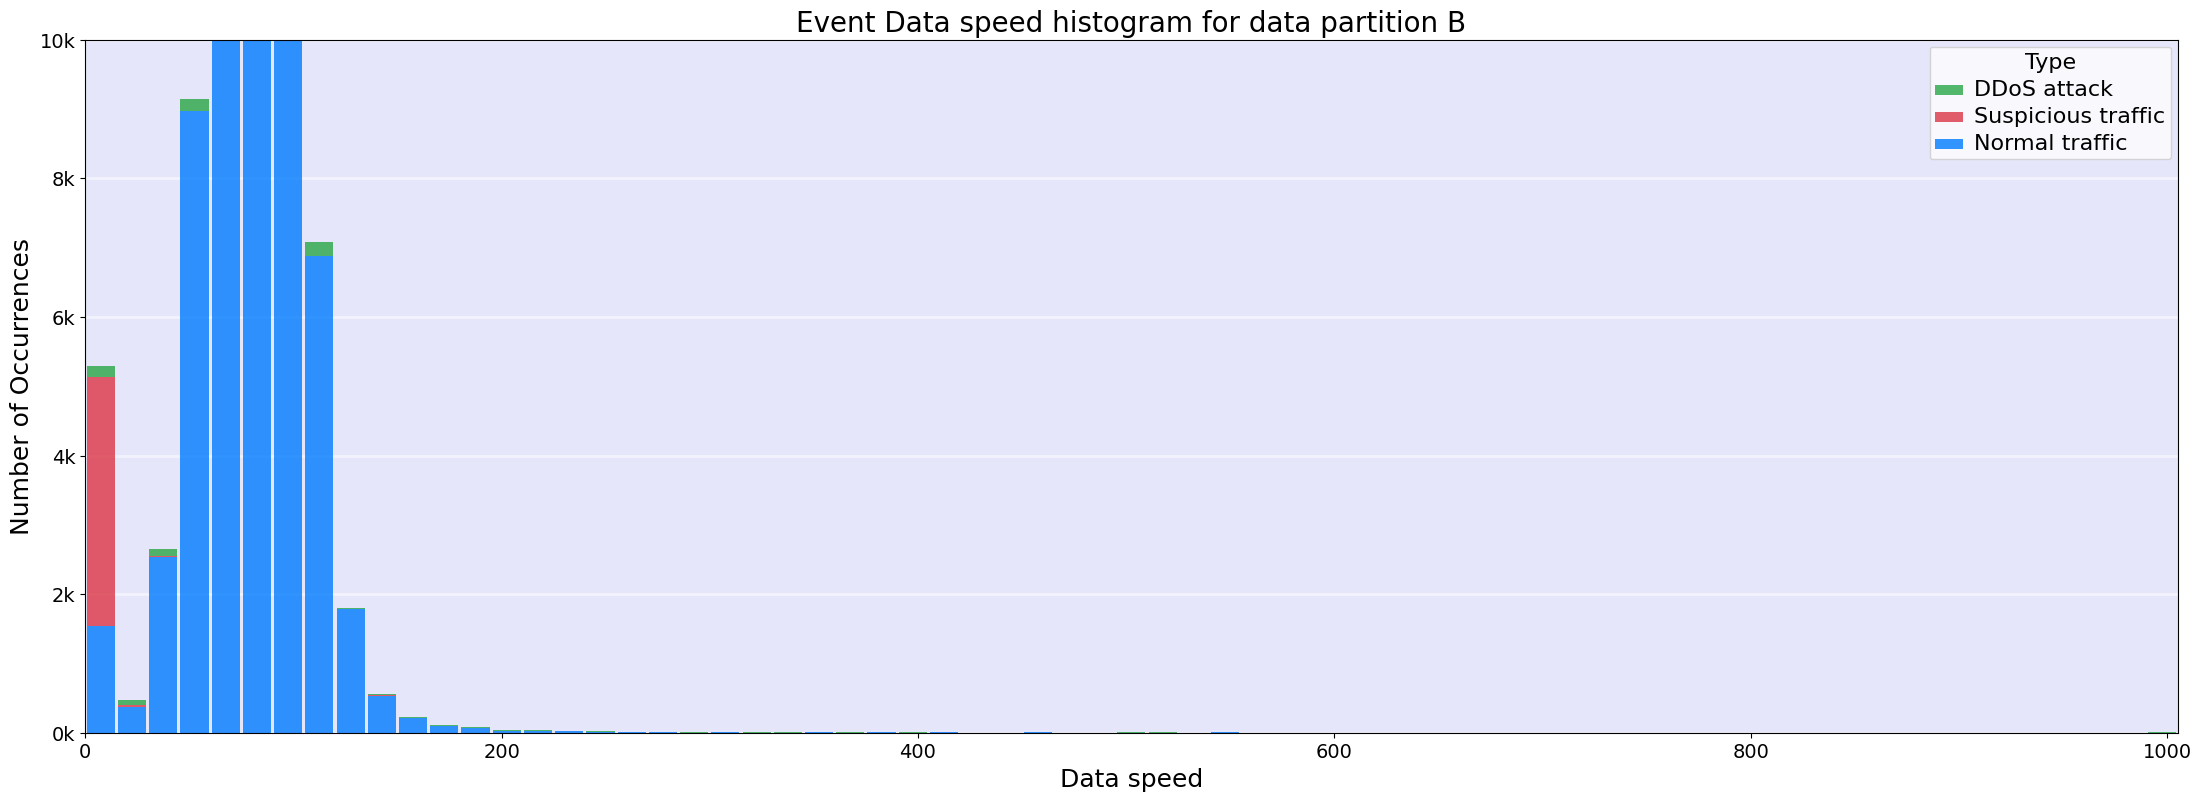

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


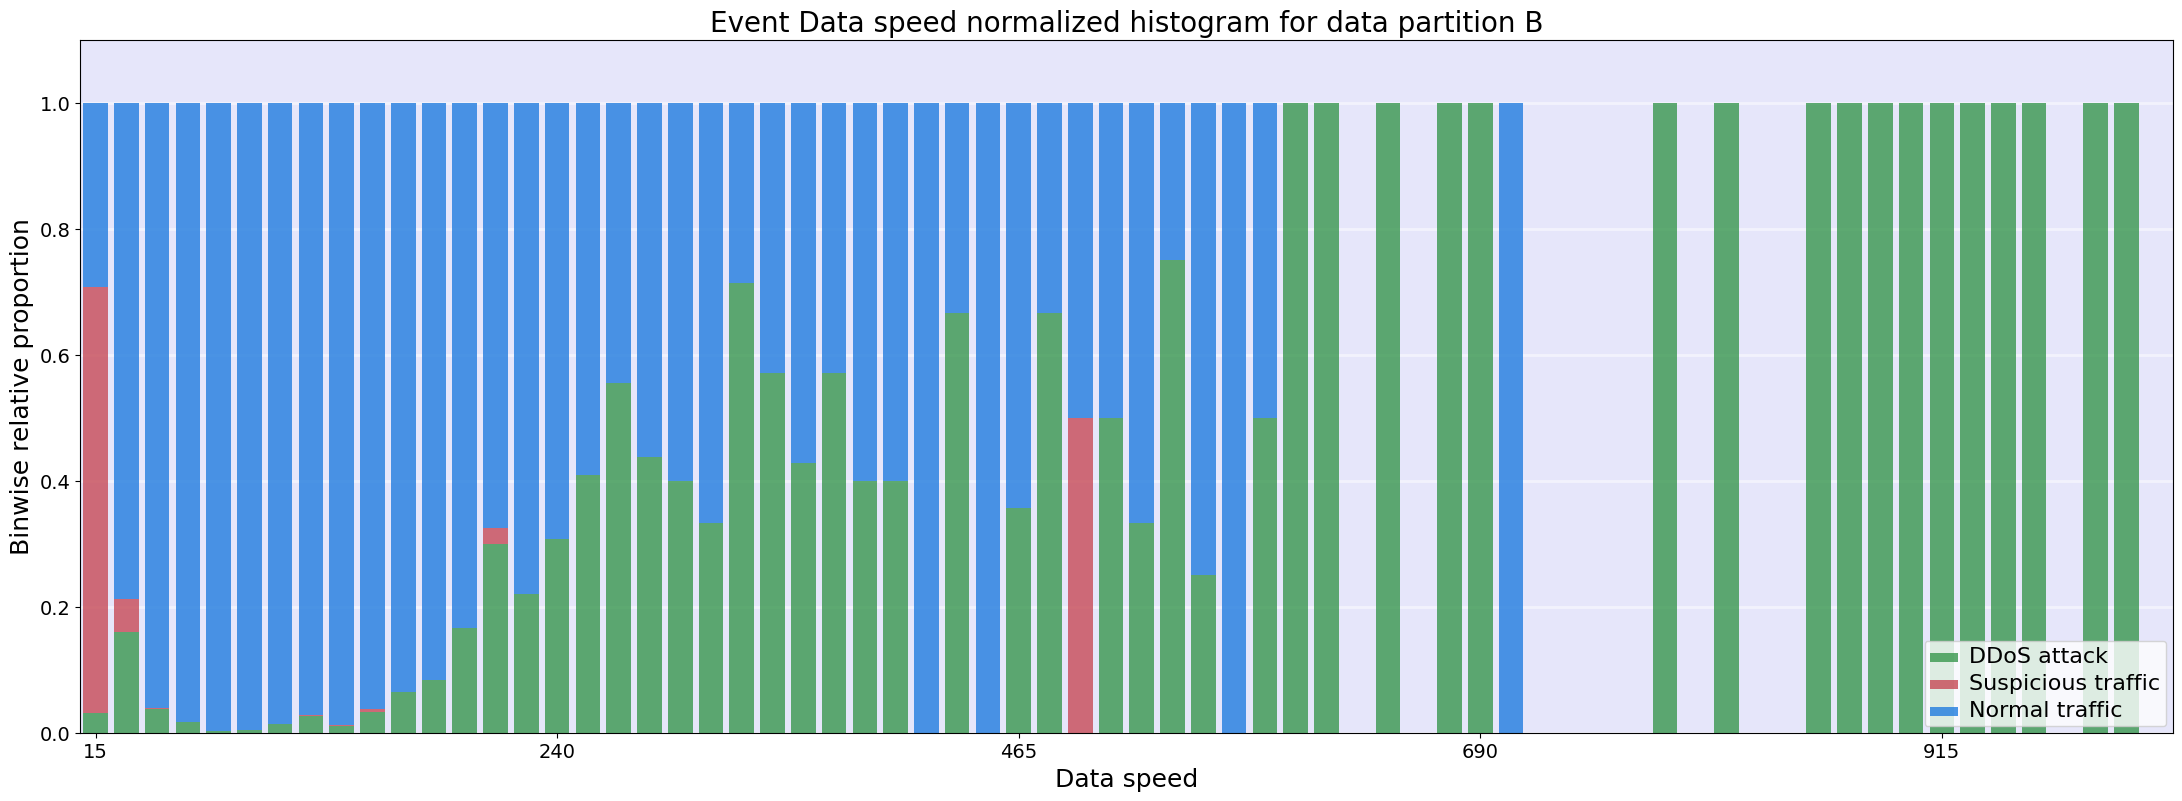

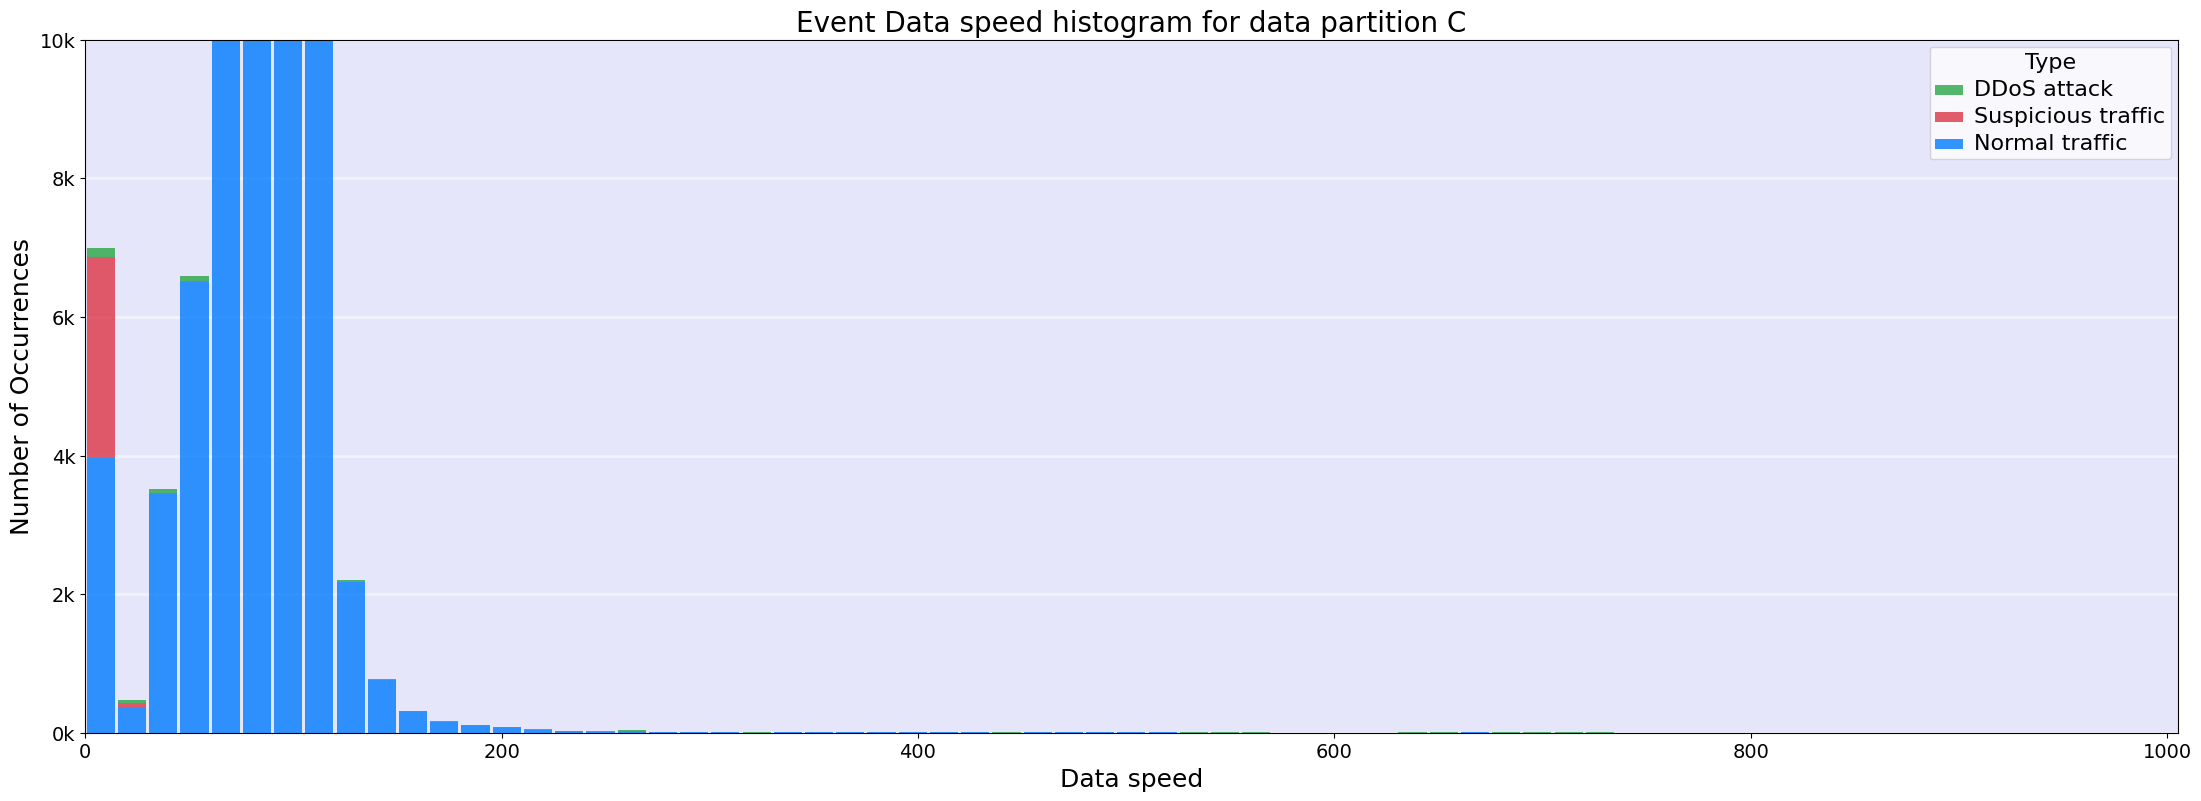

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


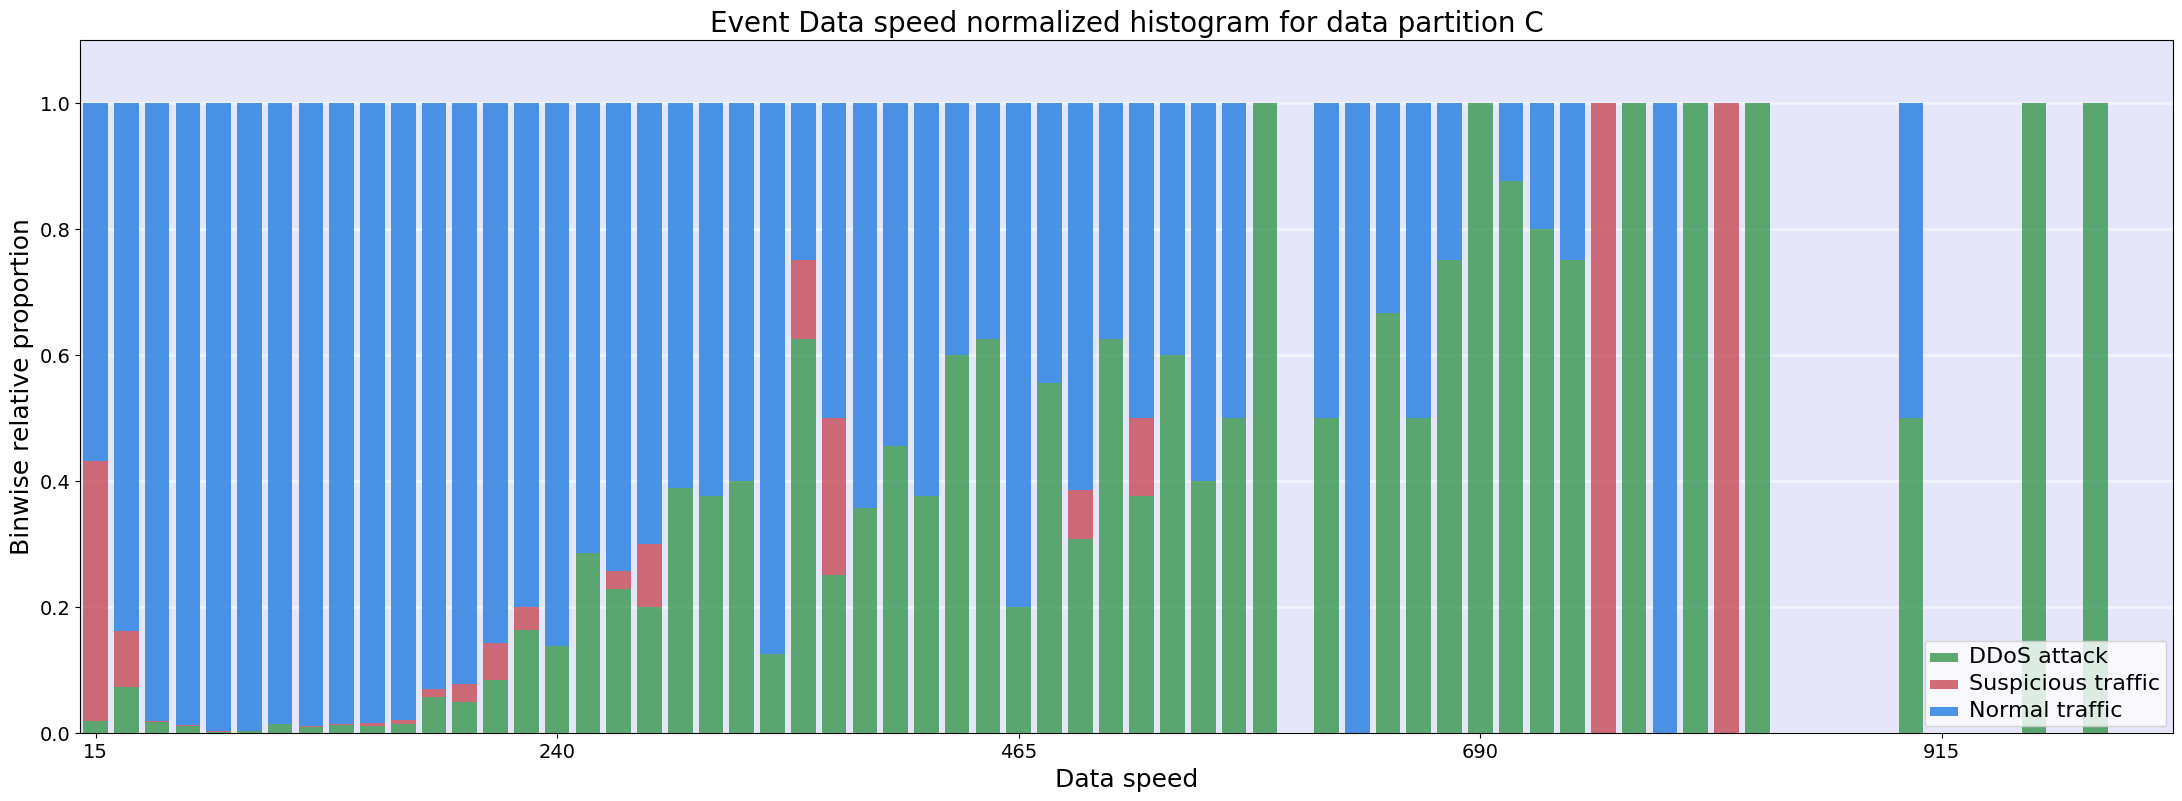

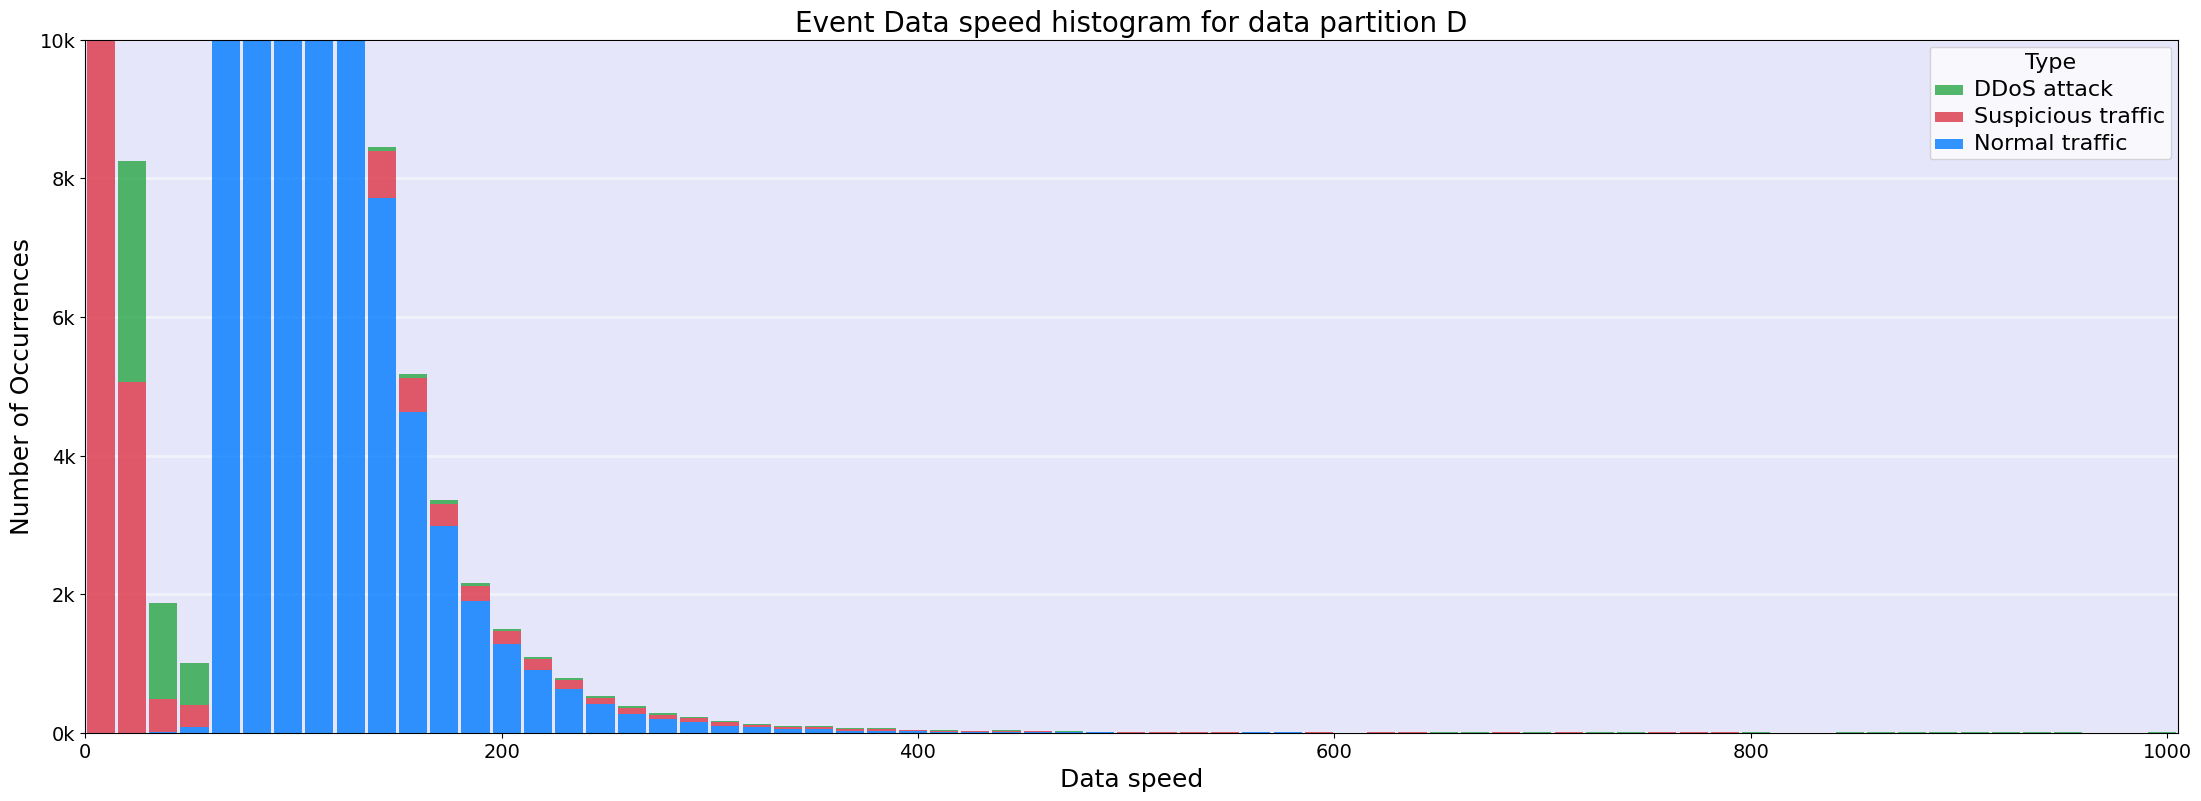

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


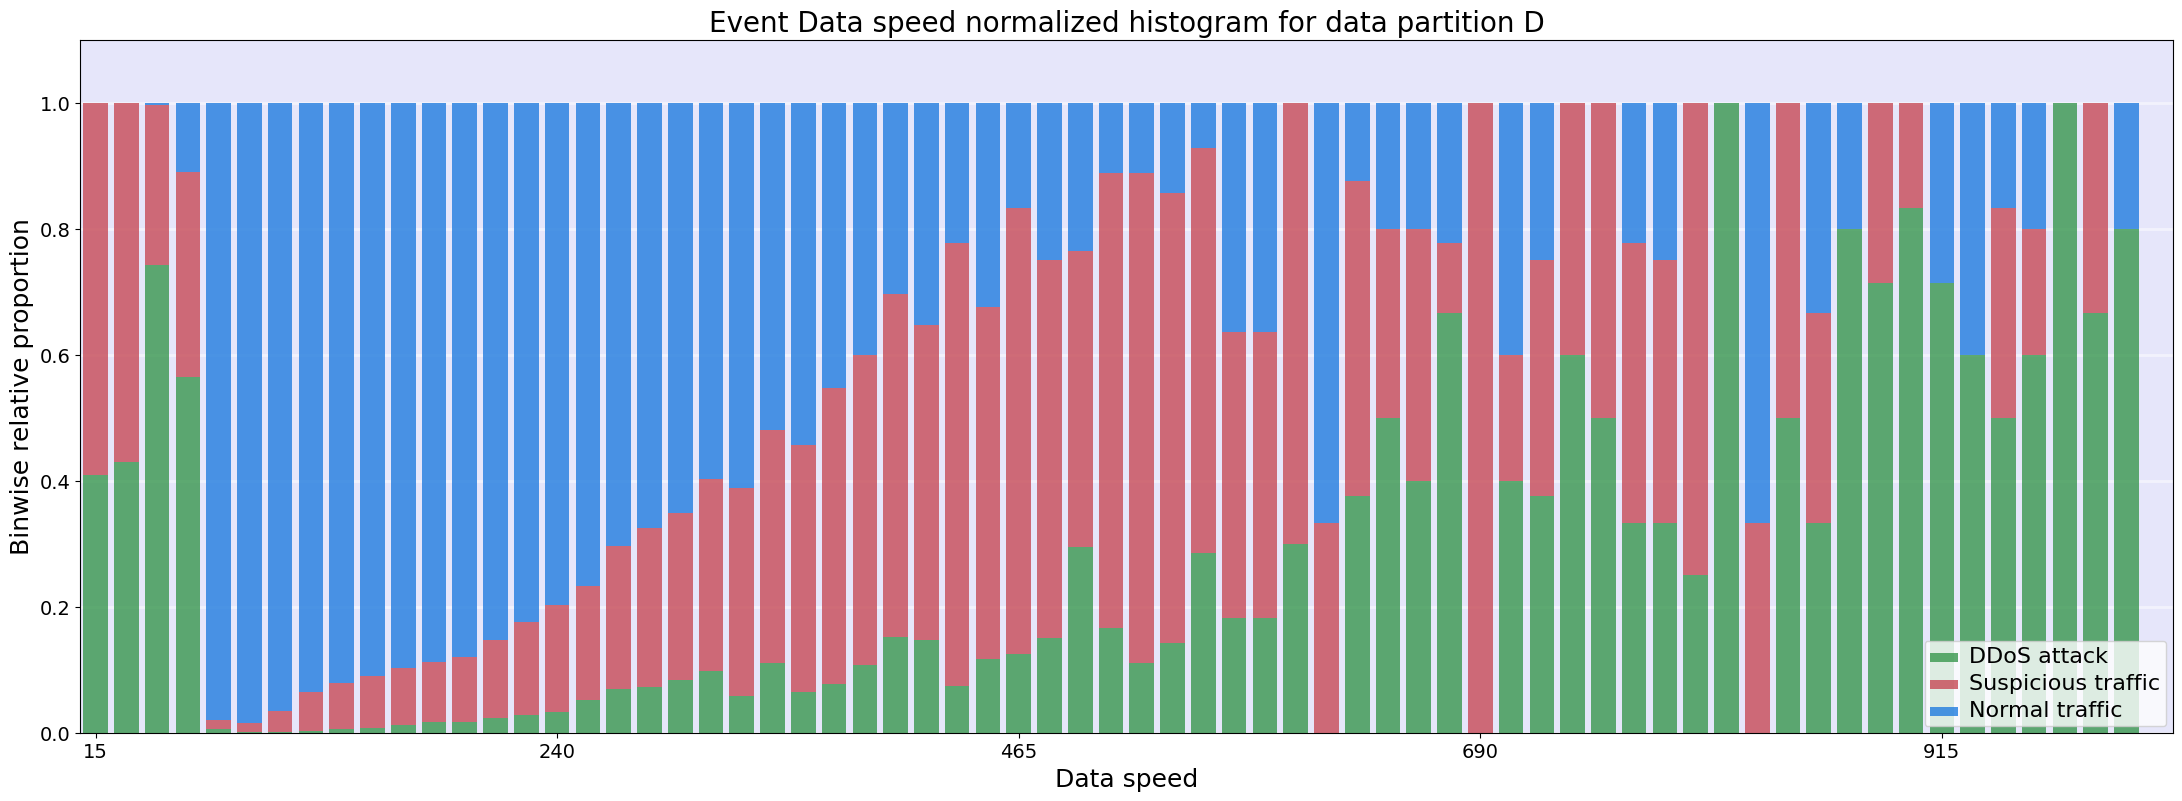

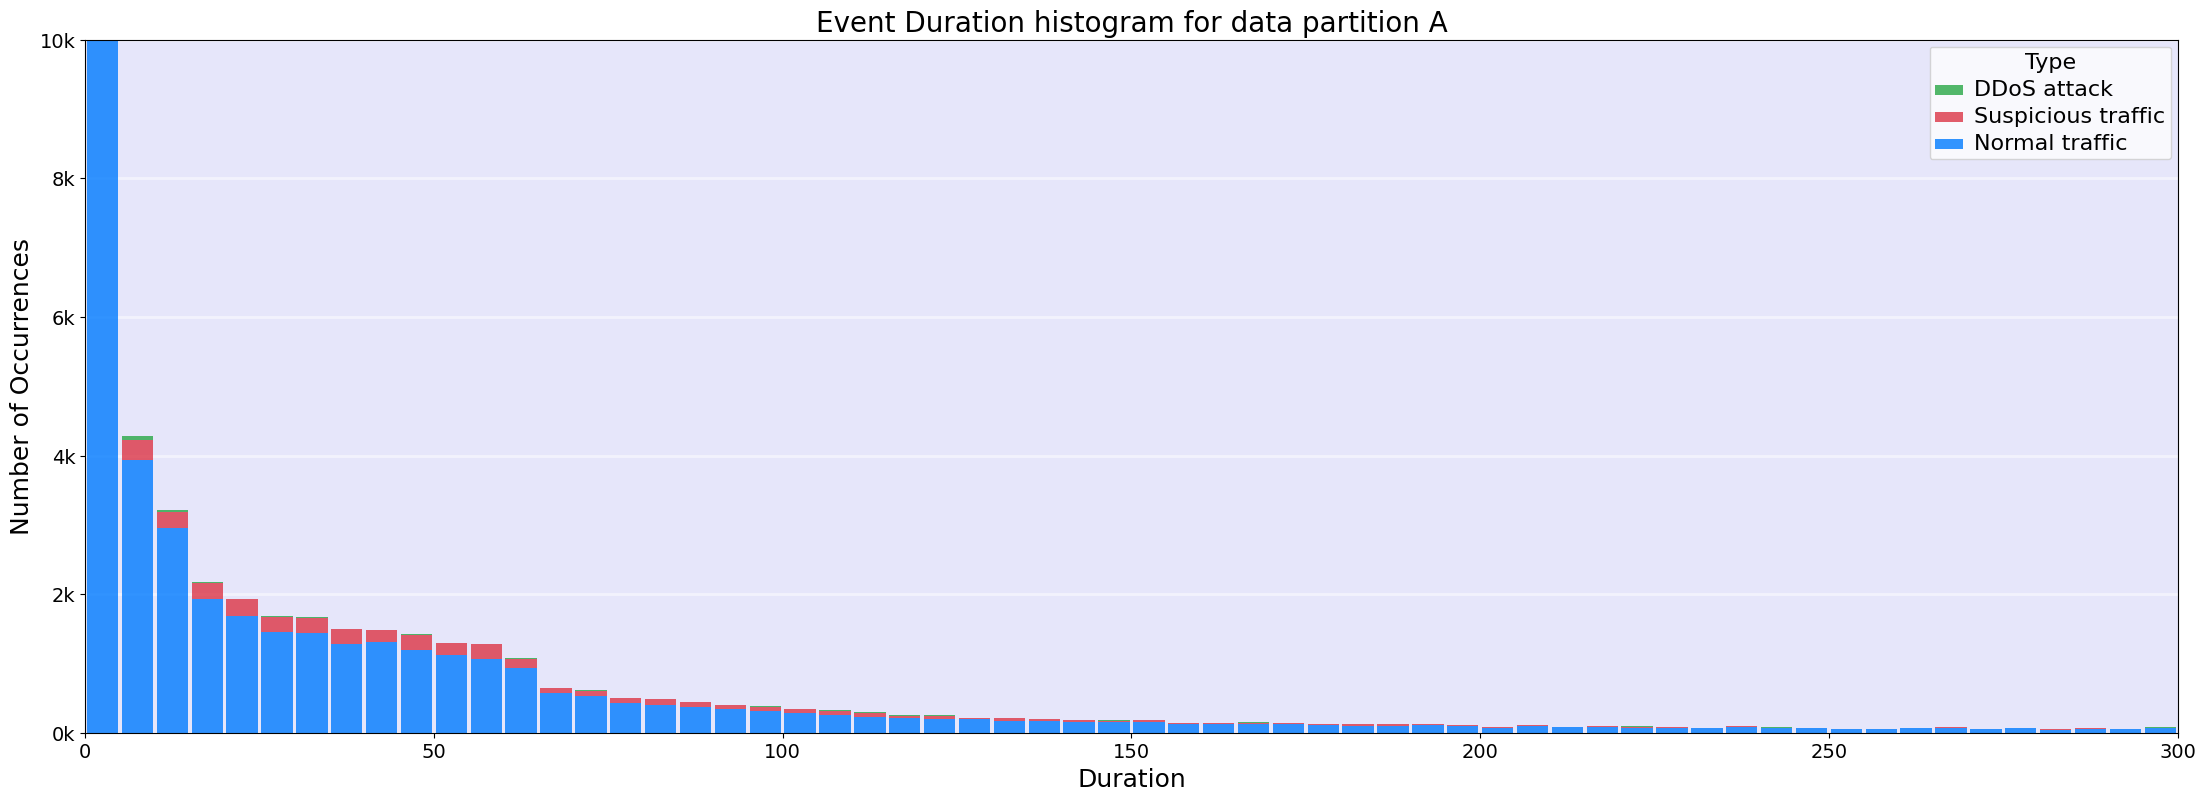

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


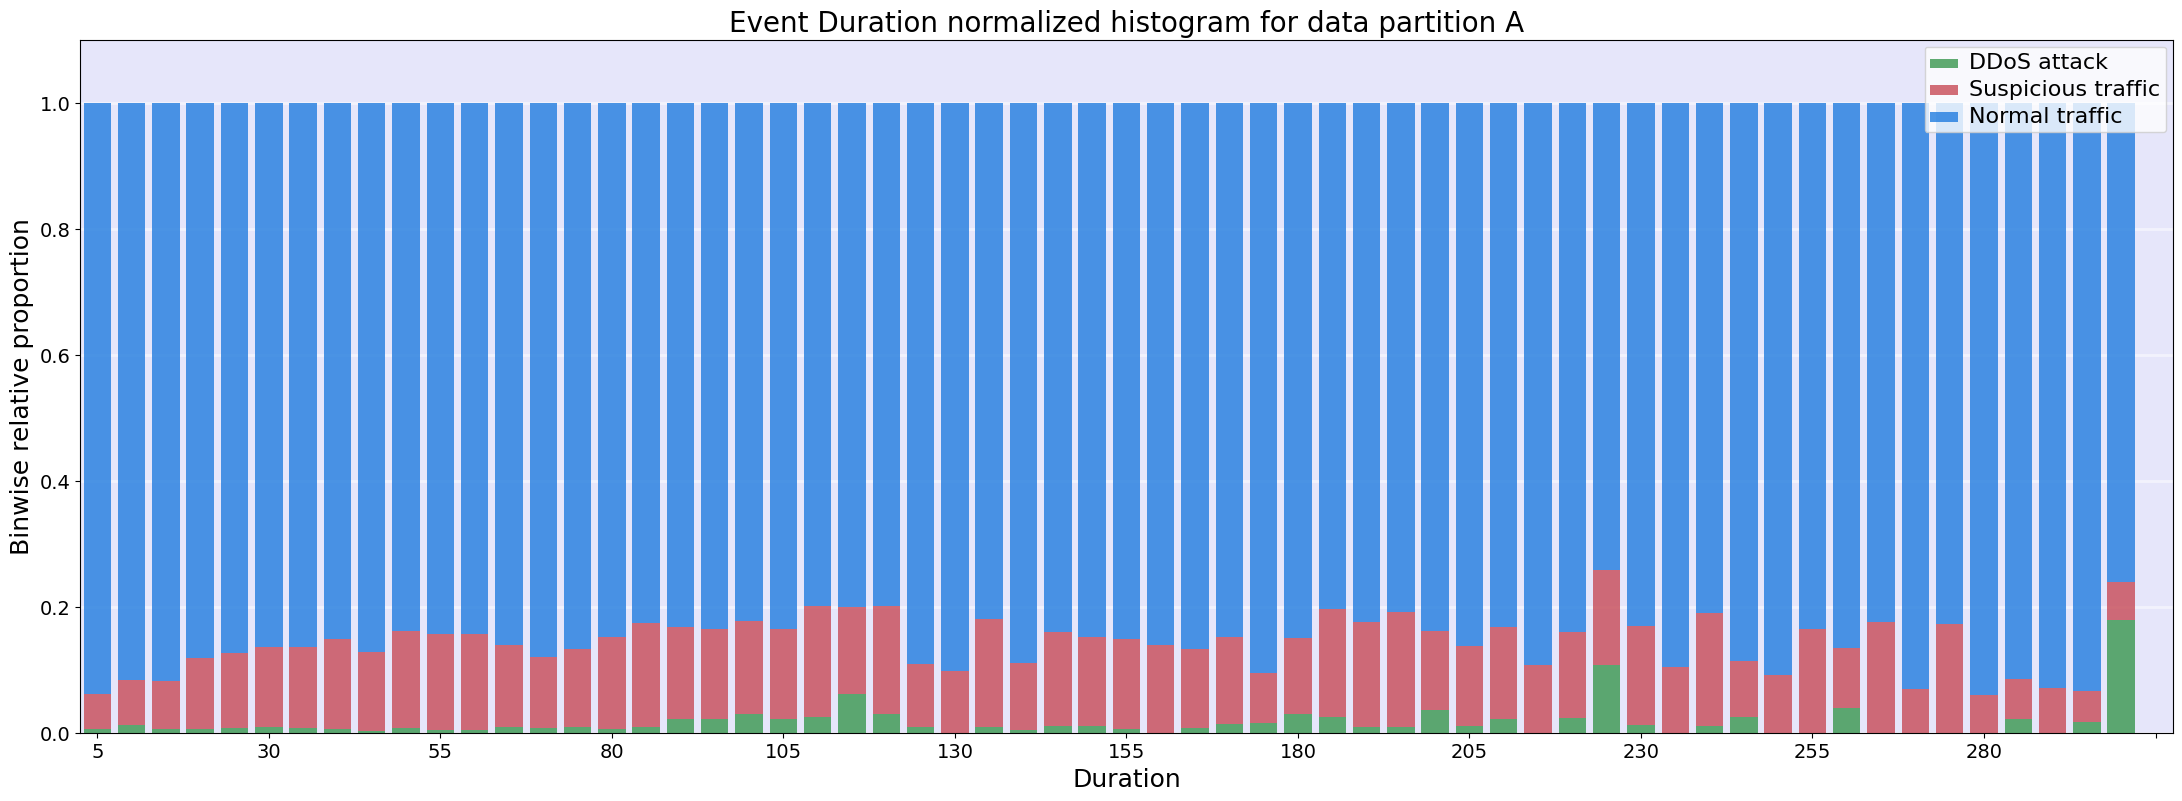

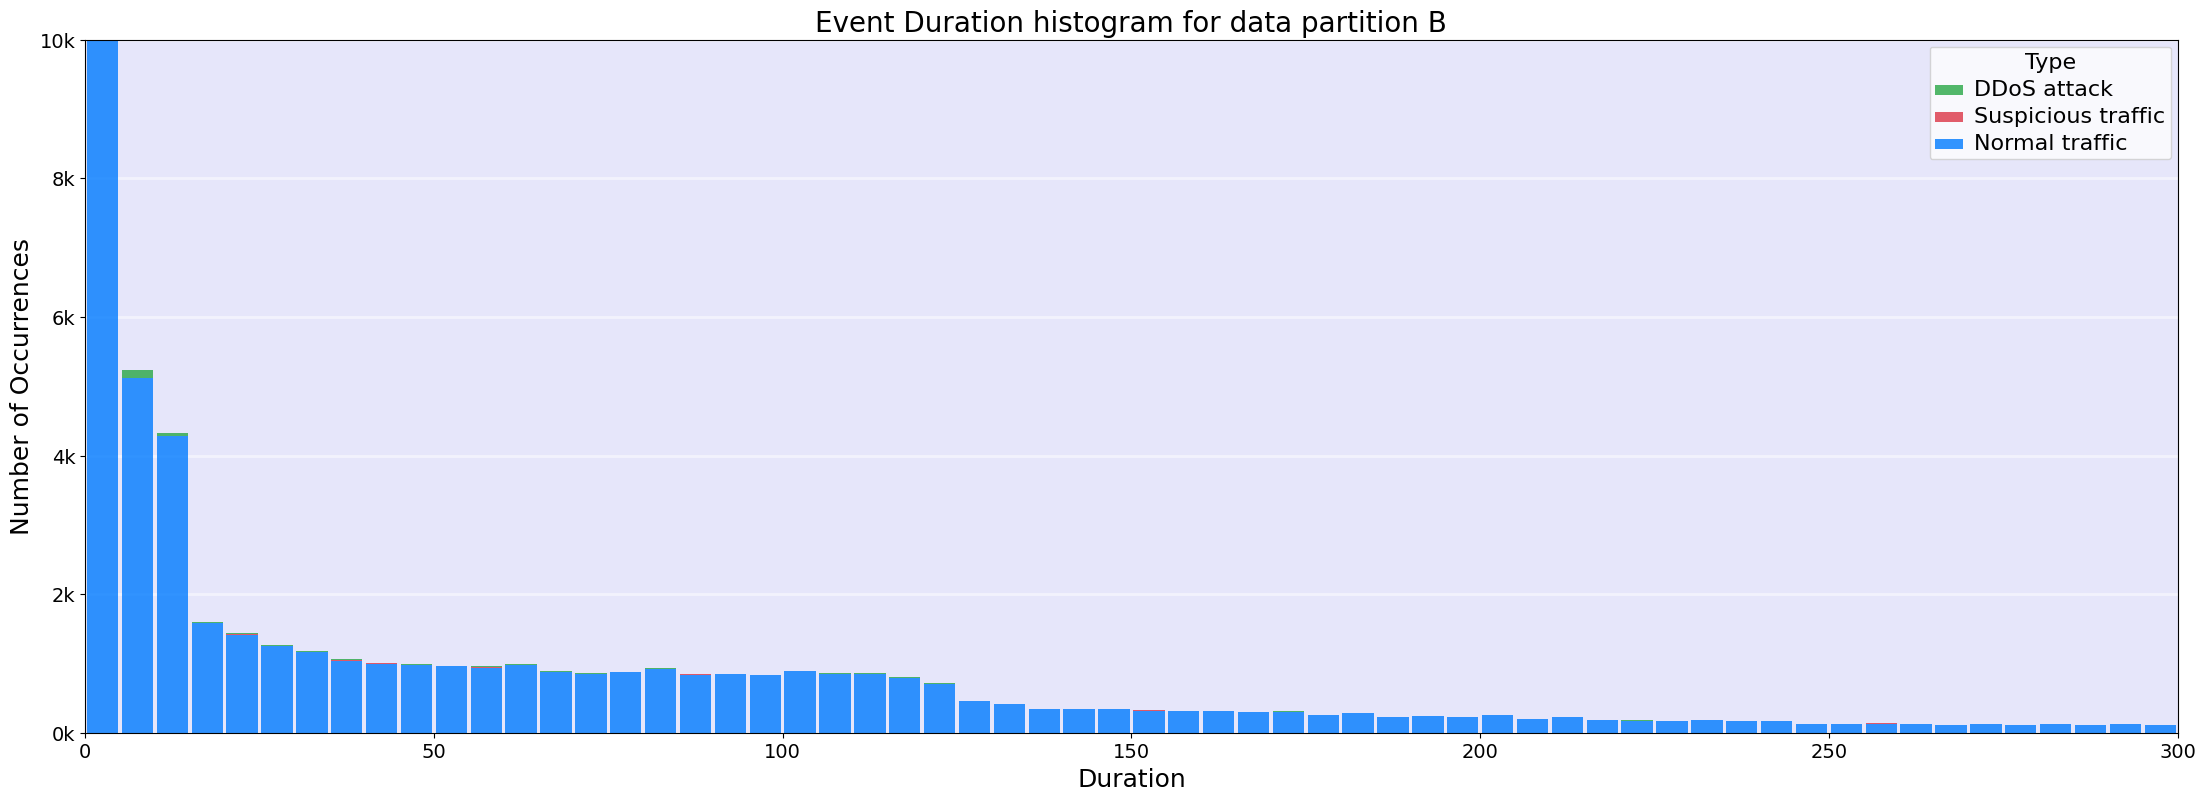

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


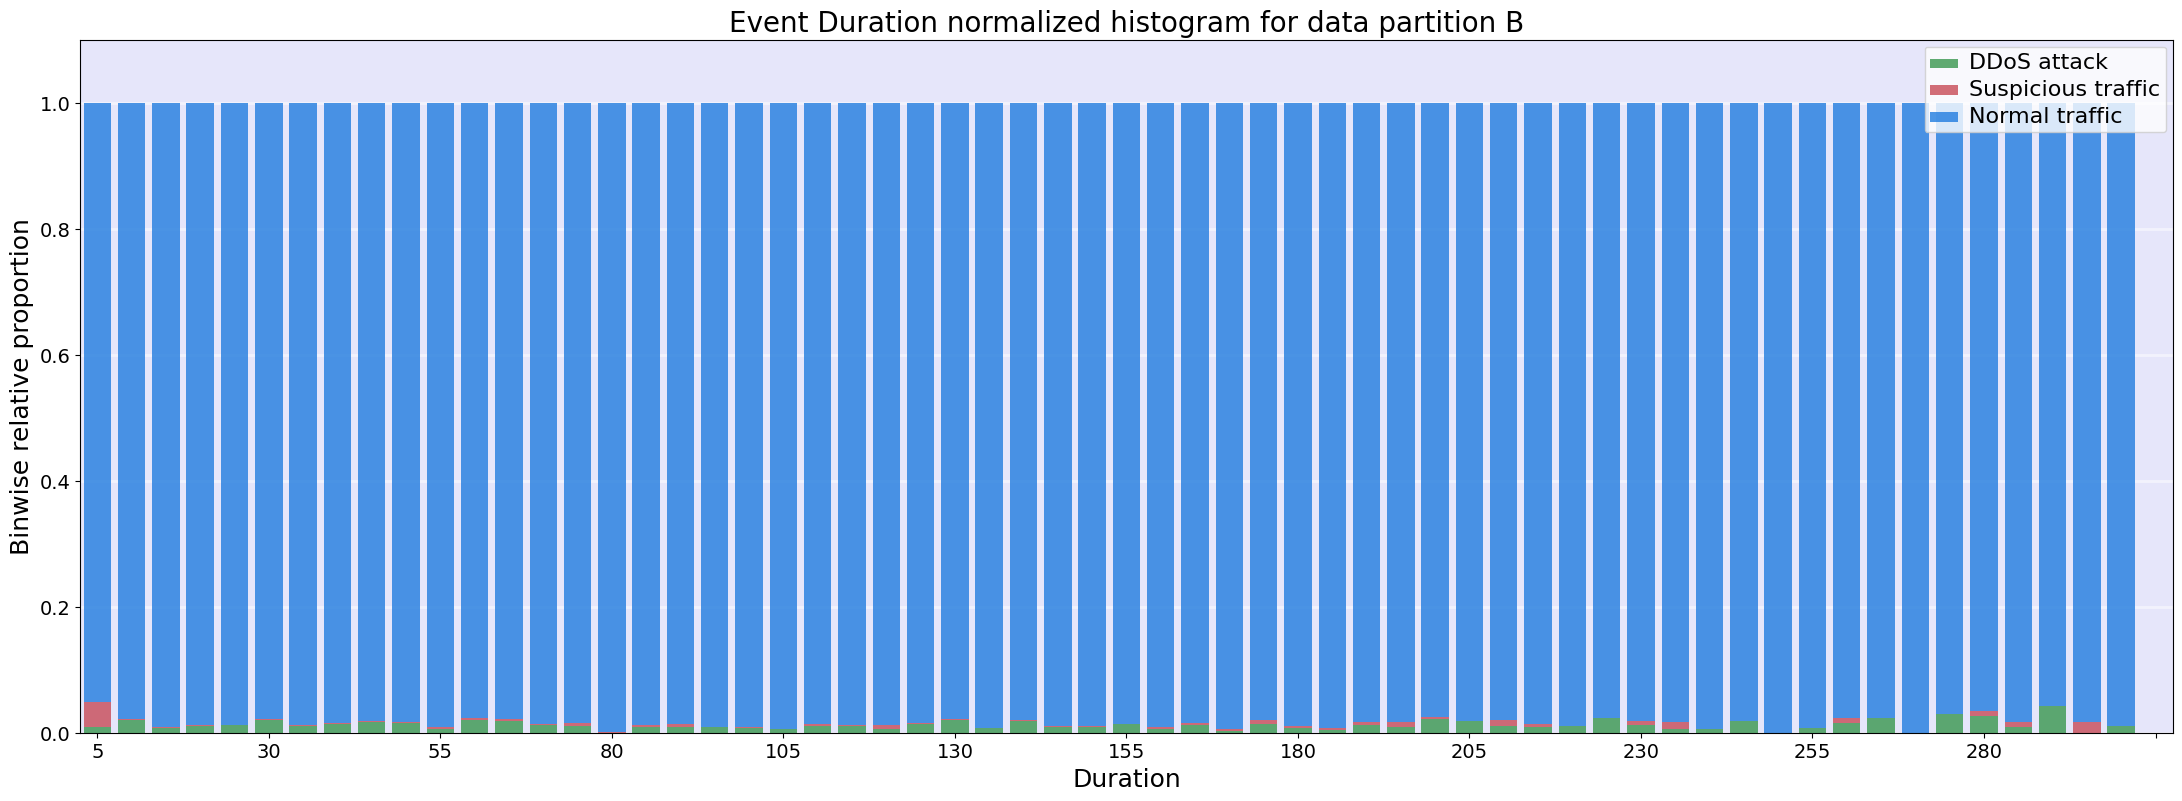

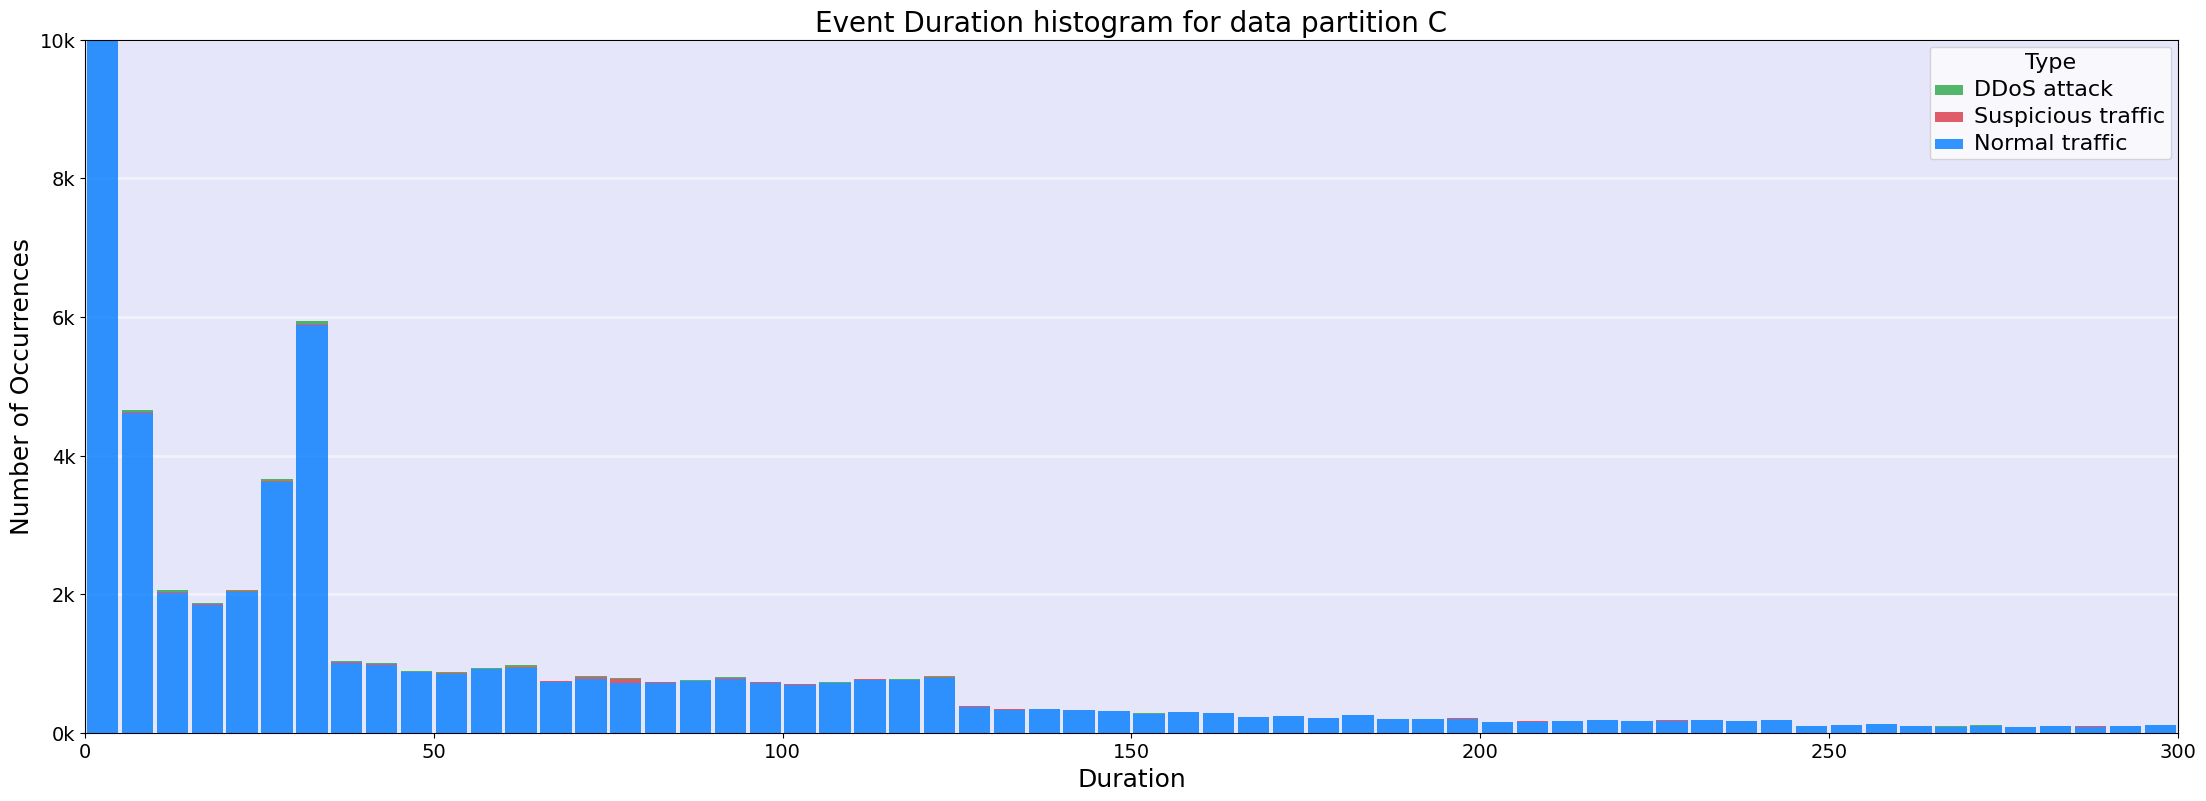

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


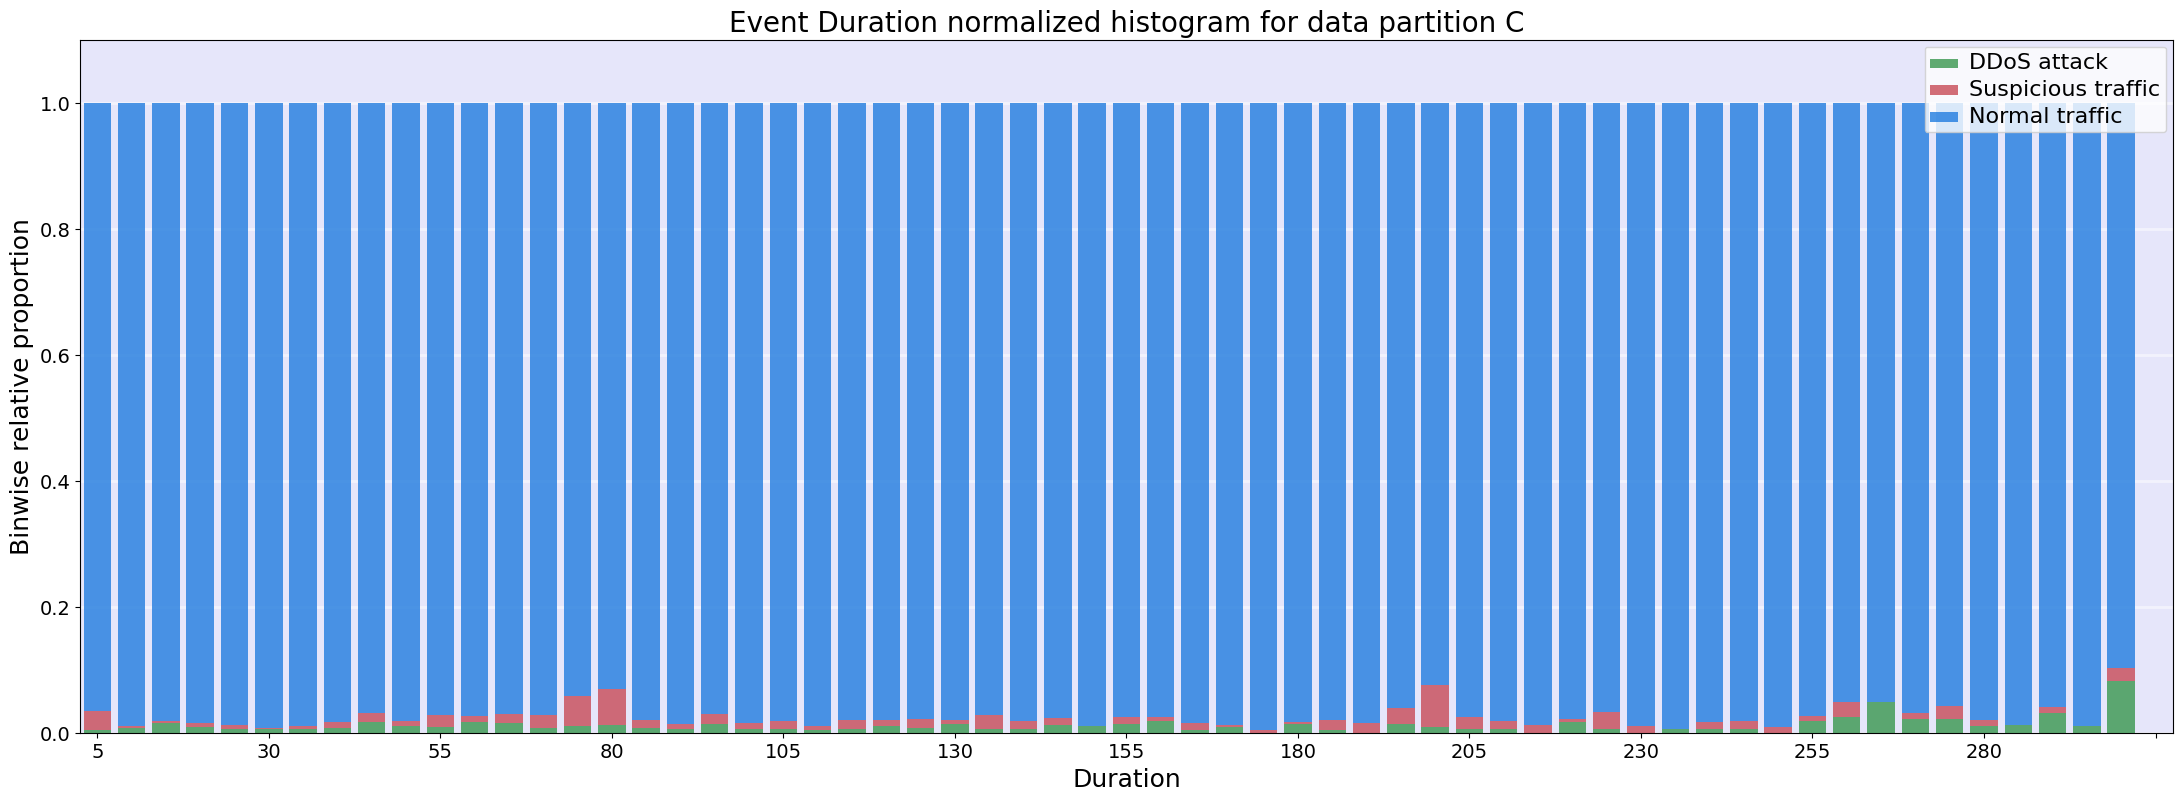

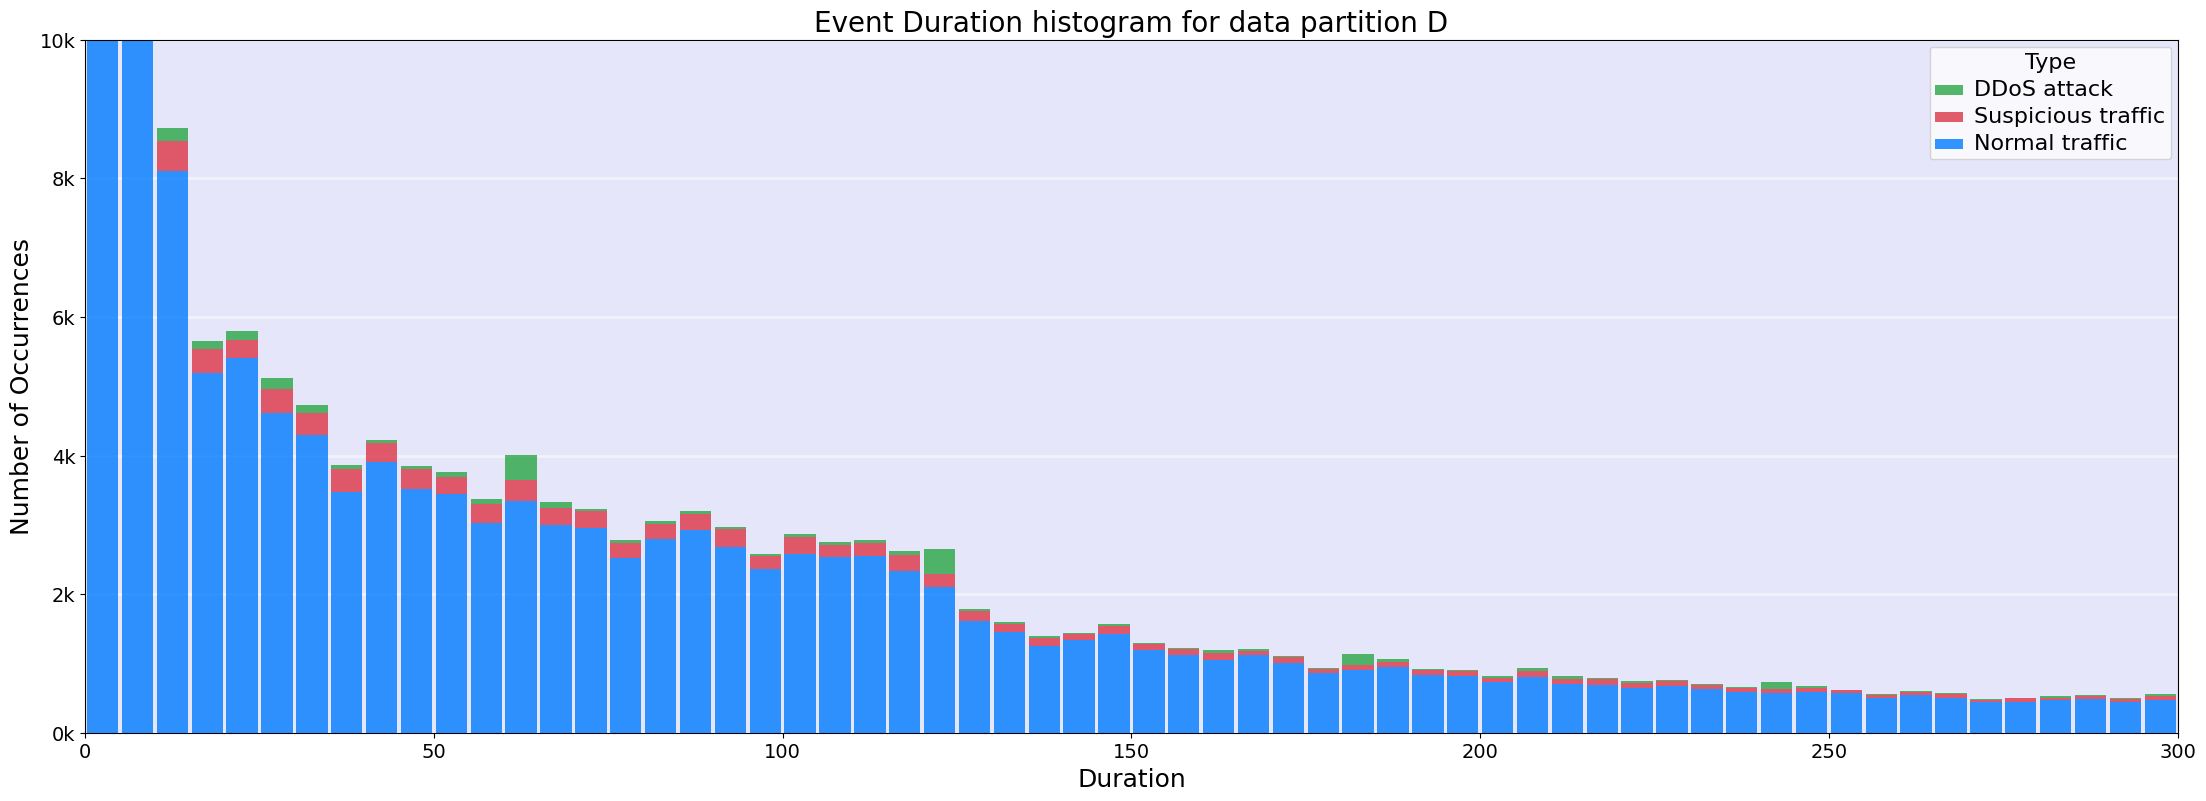

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


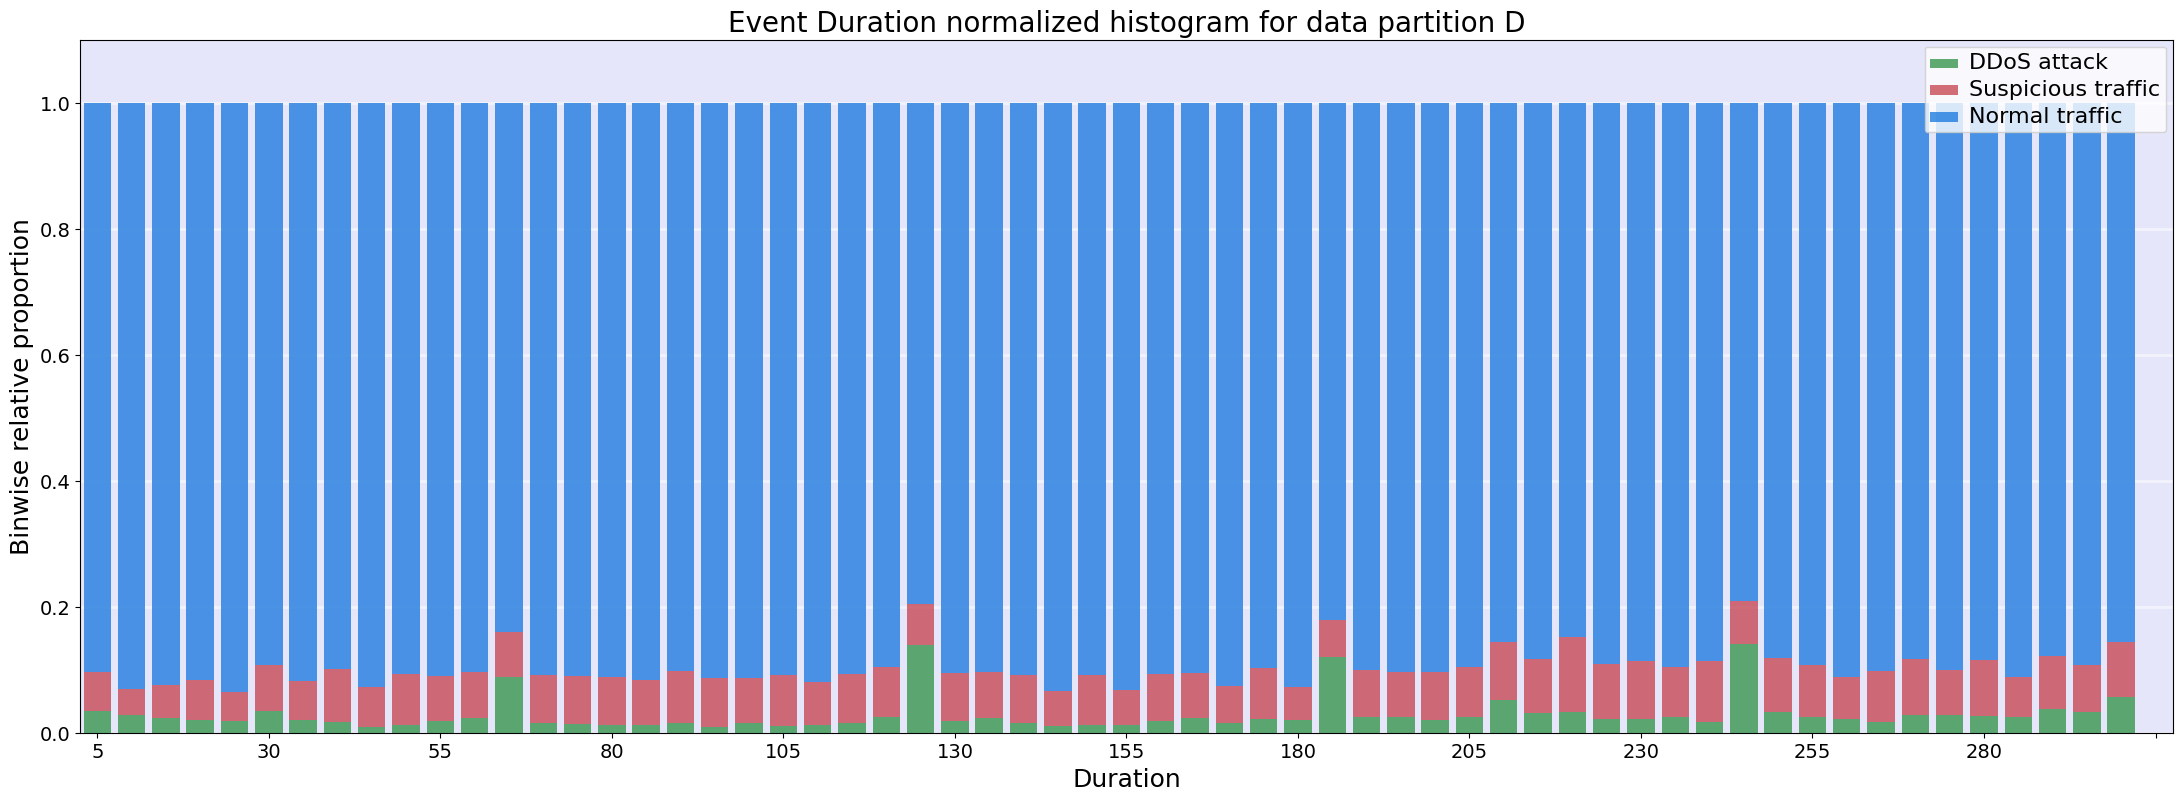

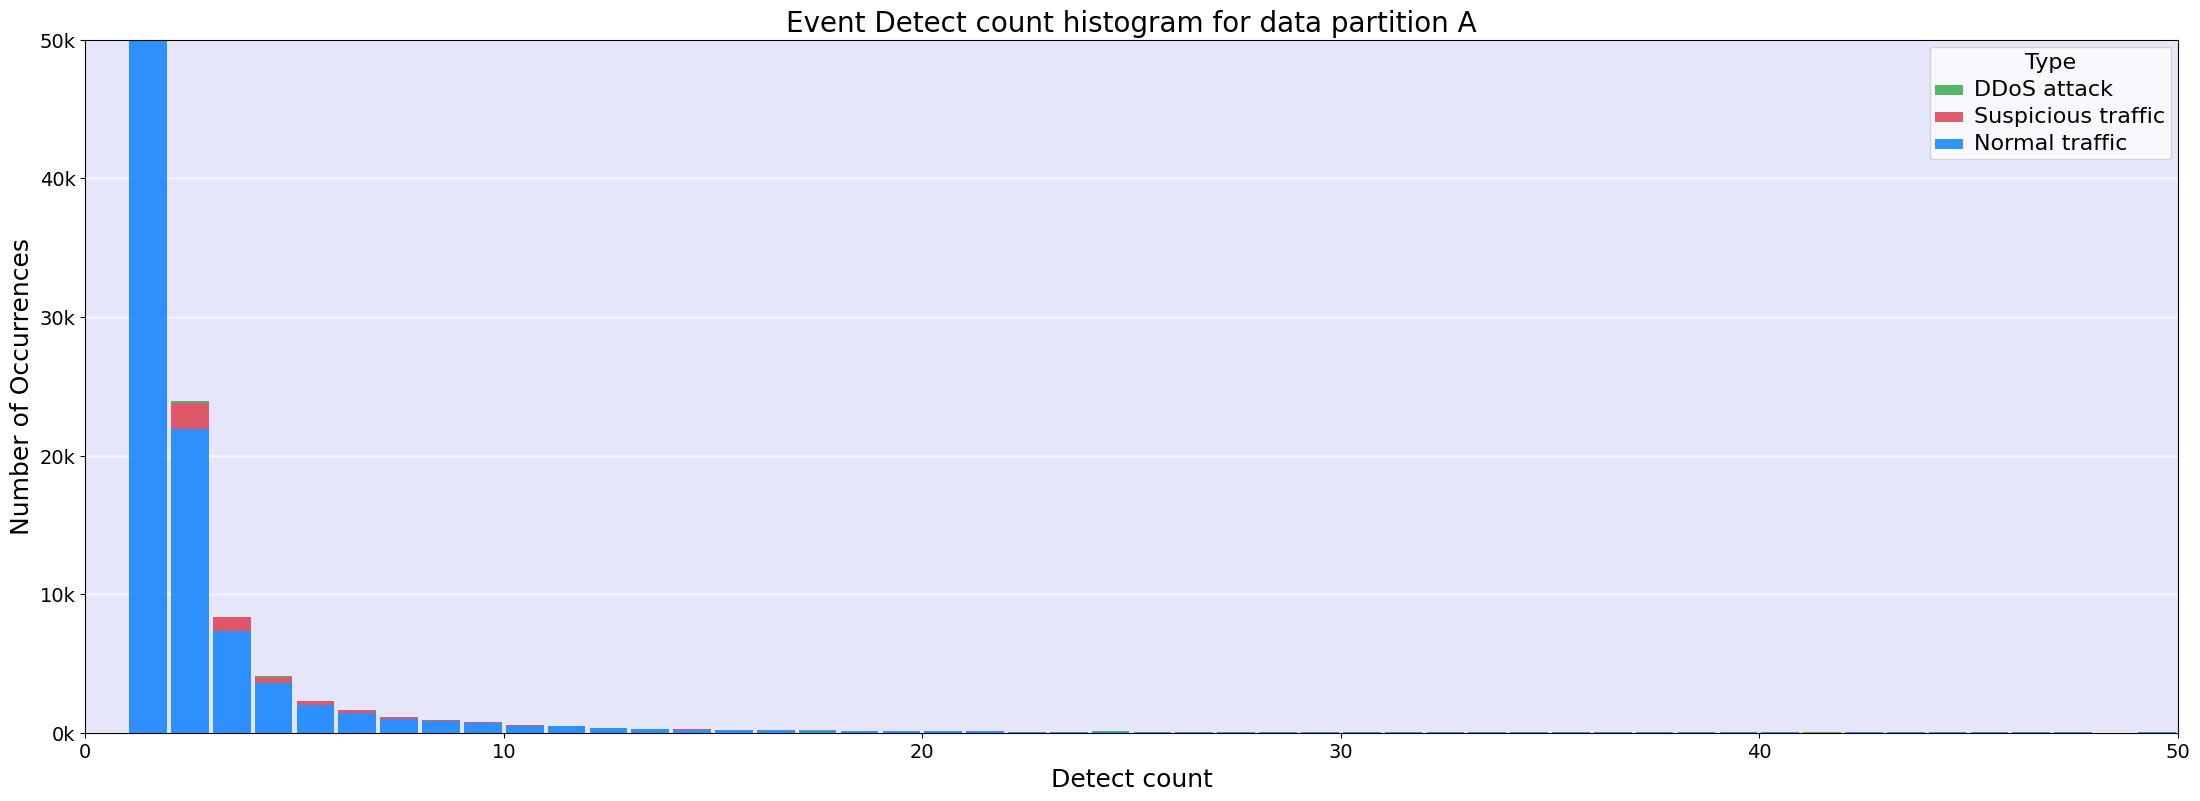

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


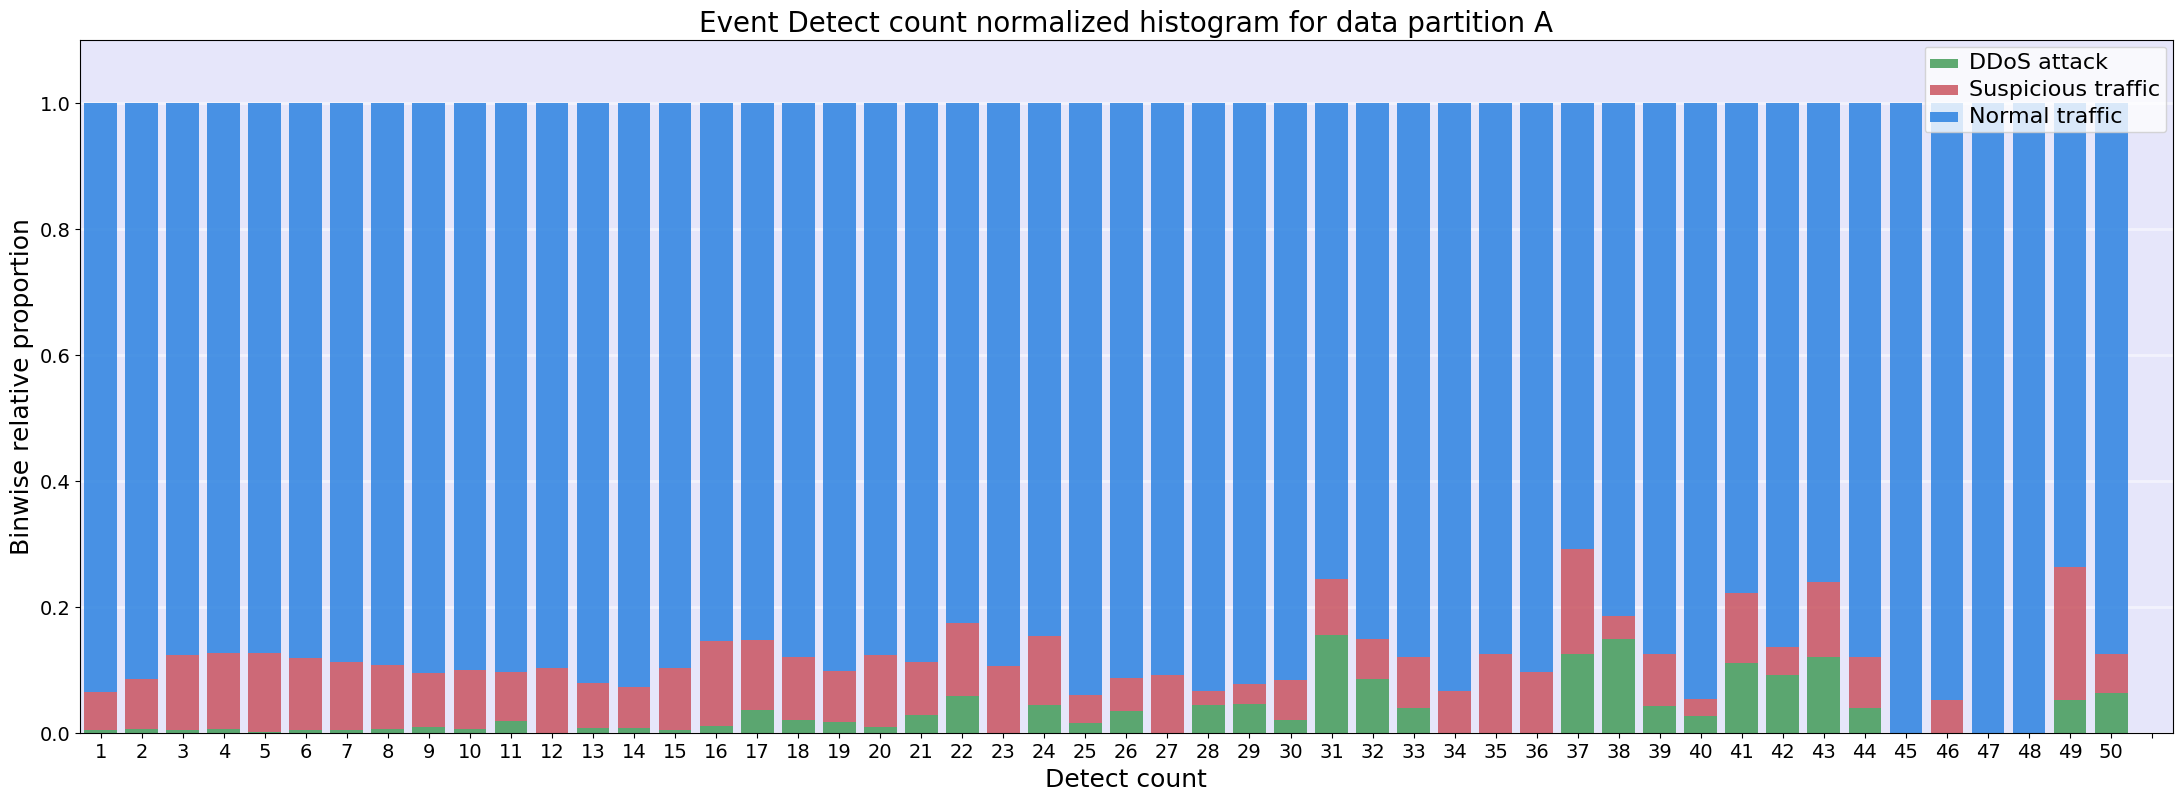

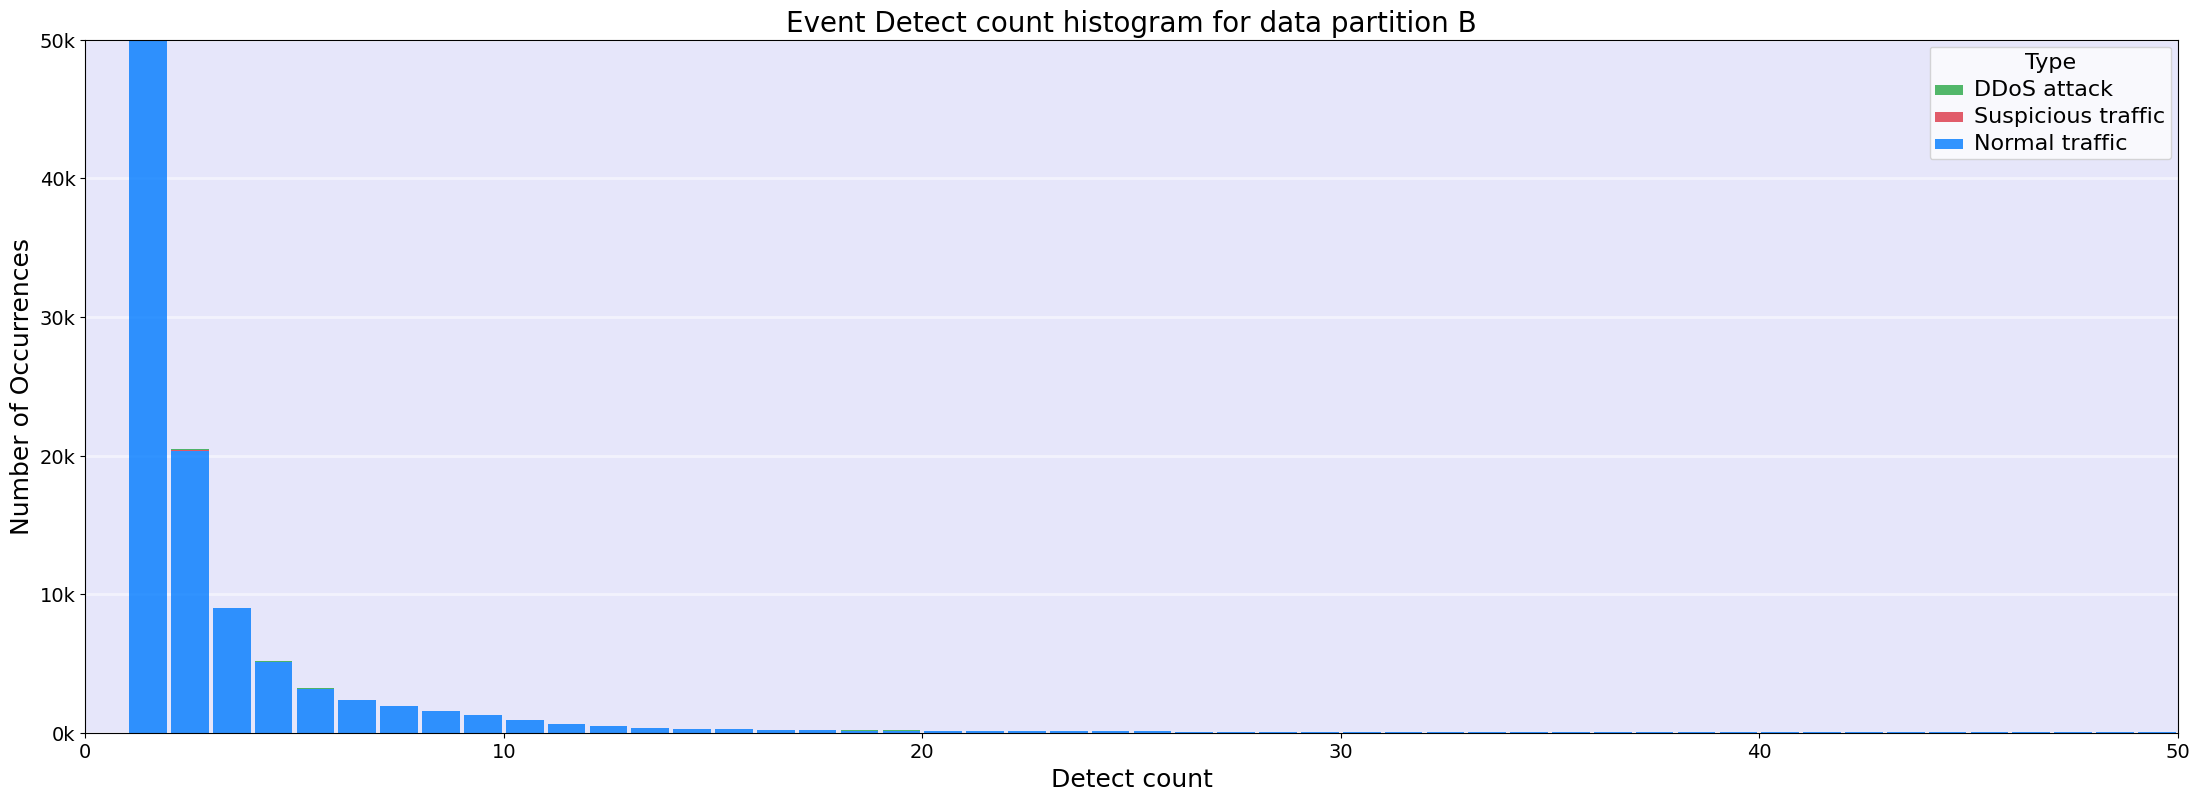

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


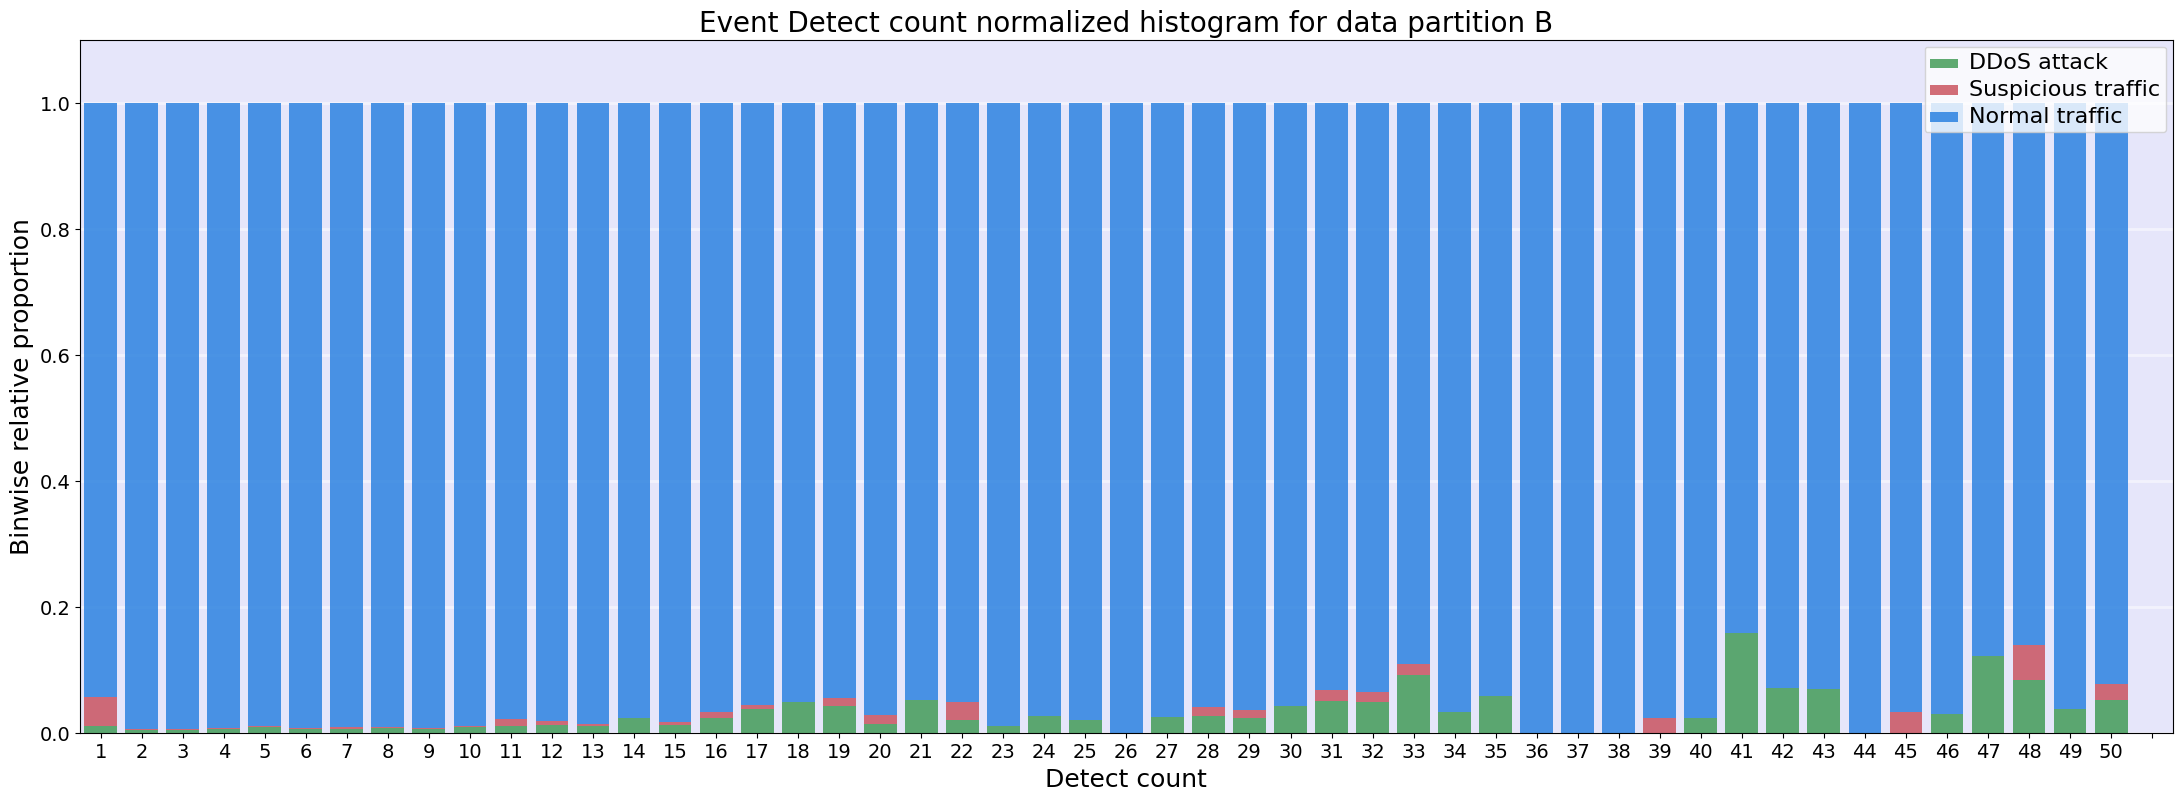

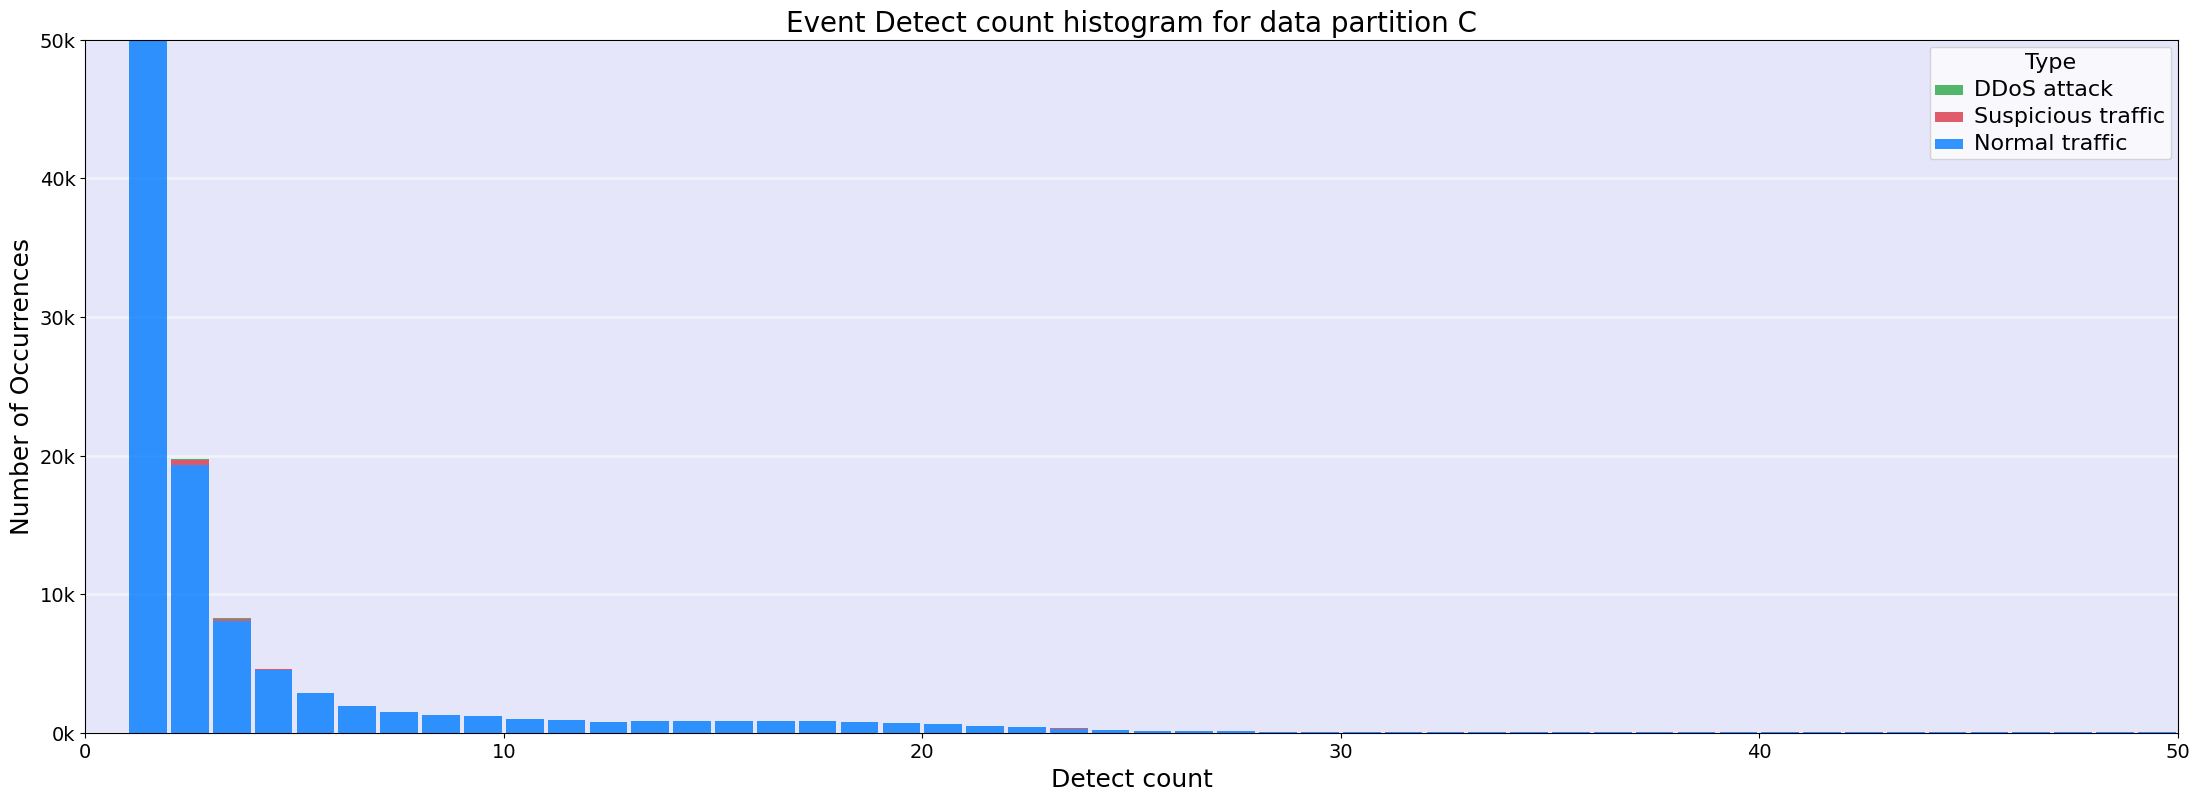

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


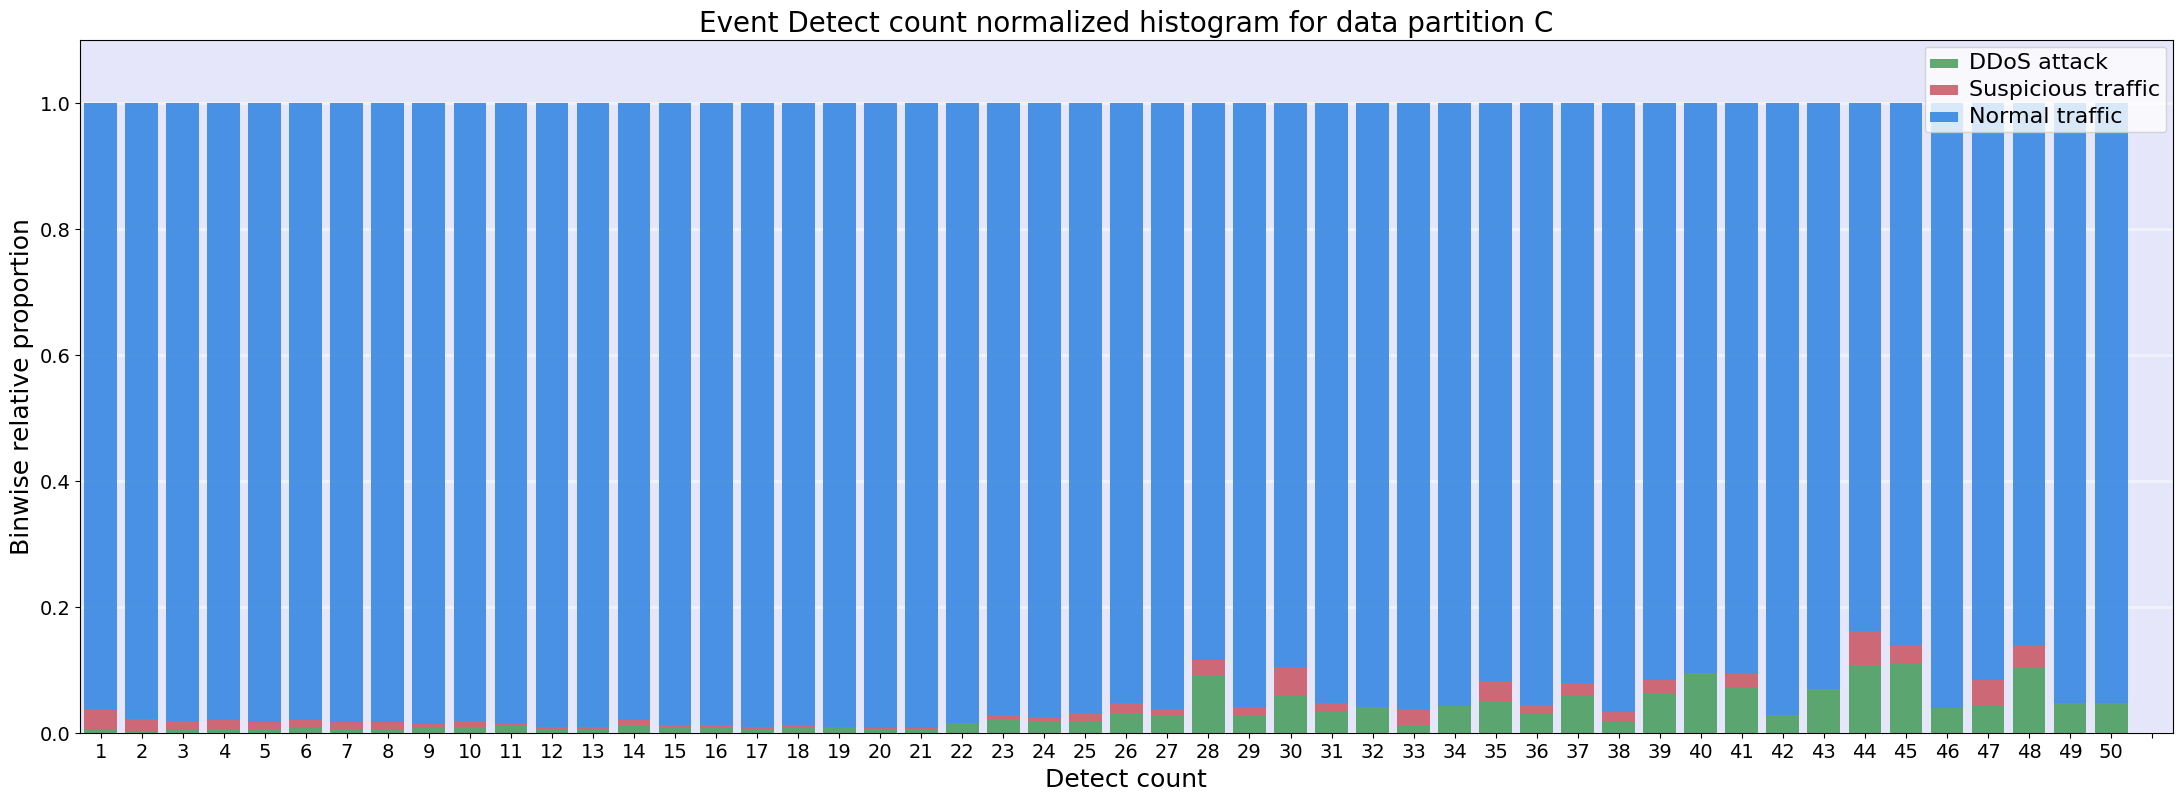

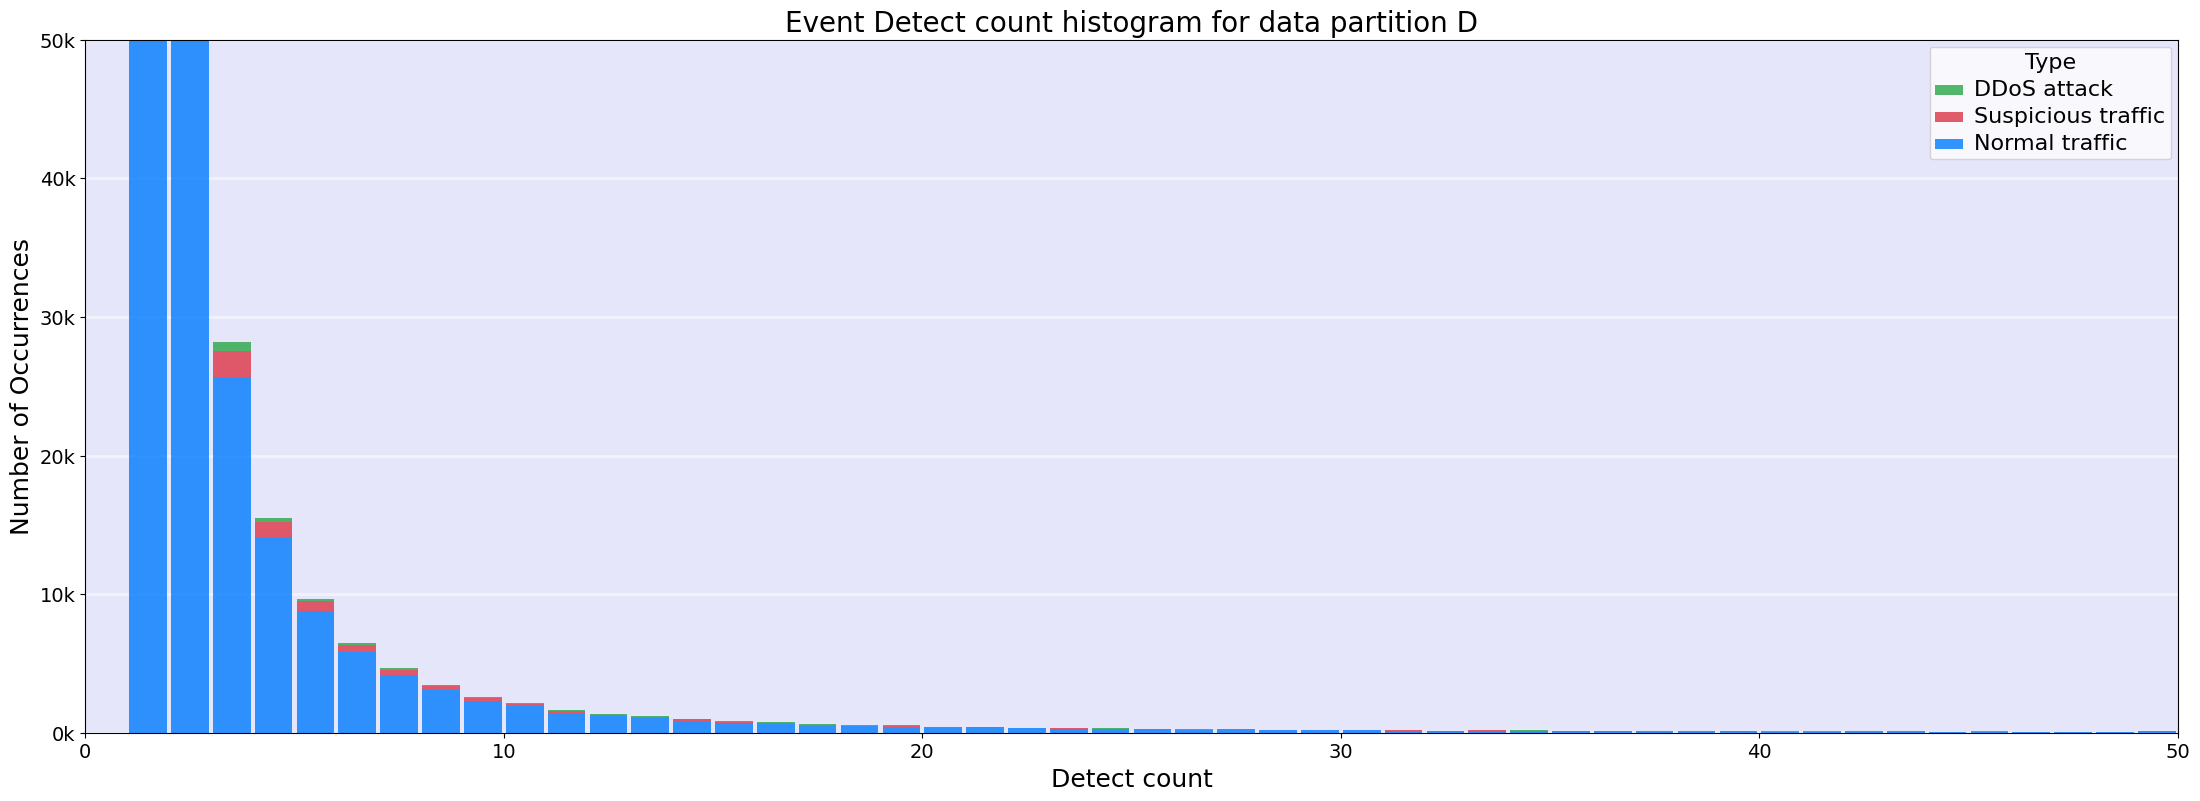

/tmp/ipykernel_130430/111123376.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


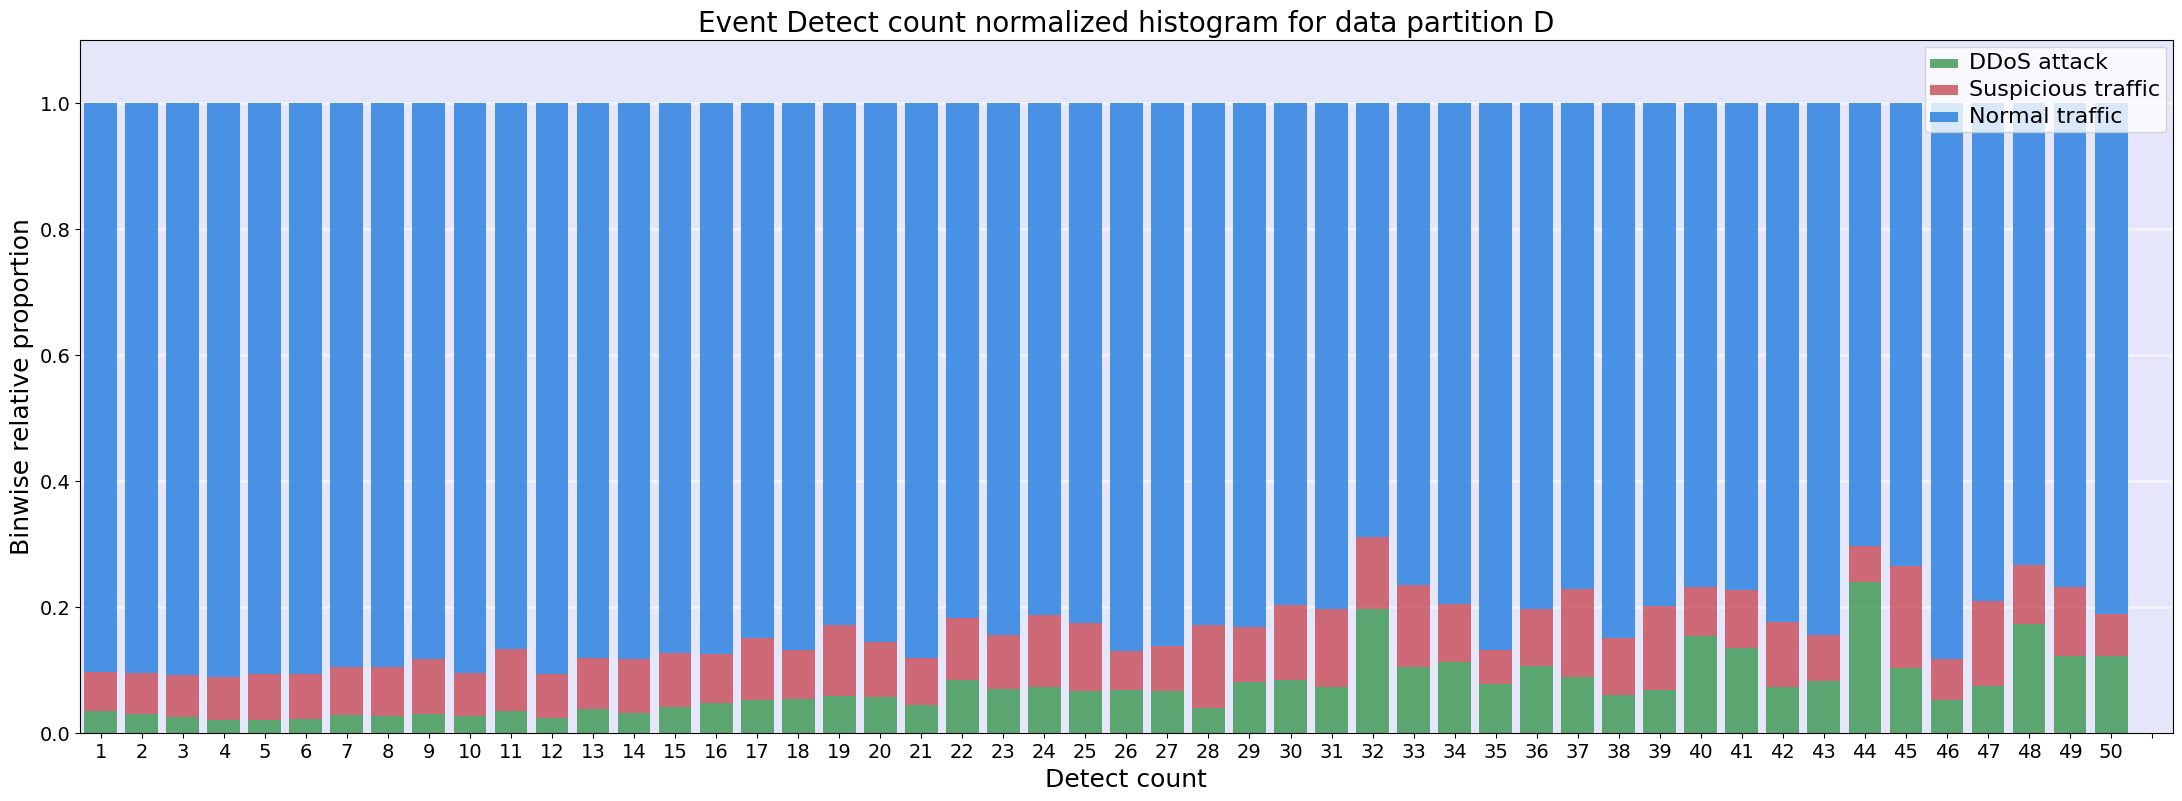

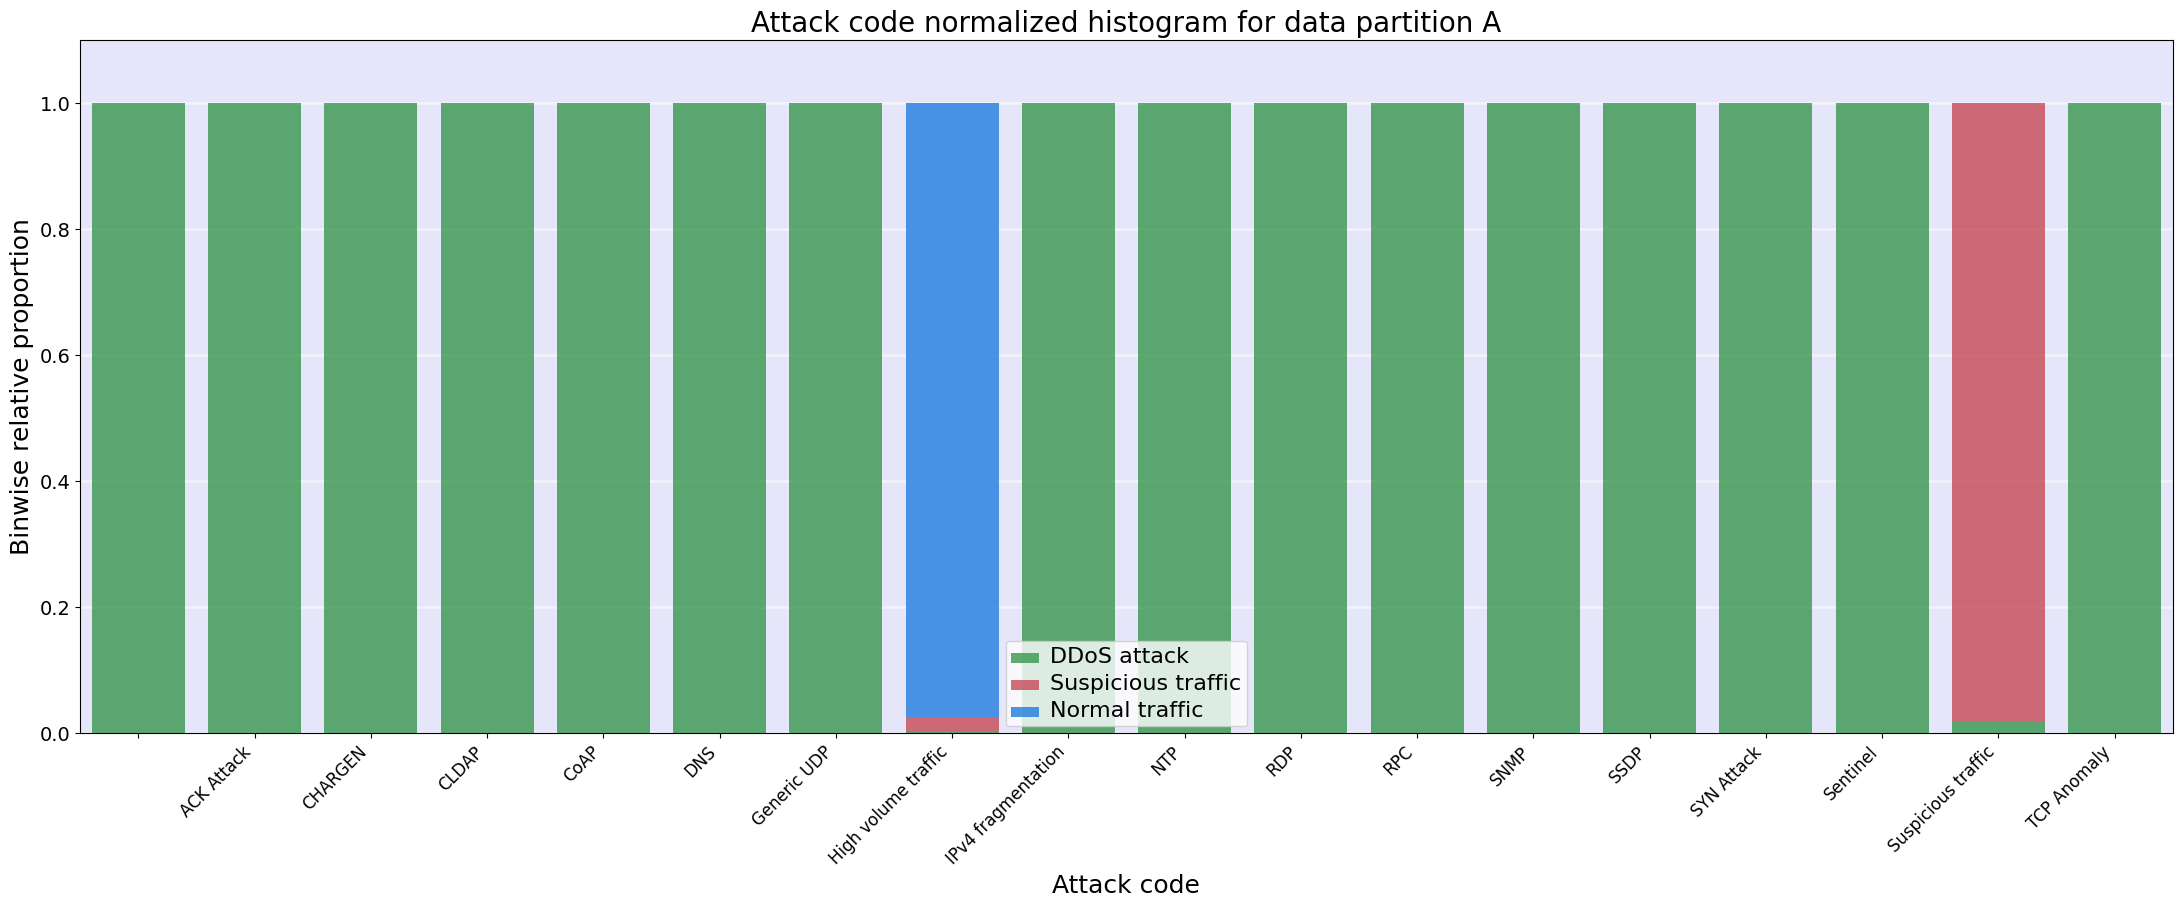

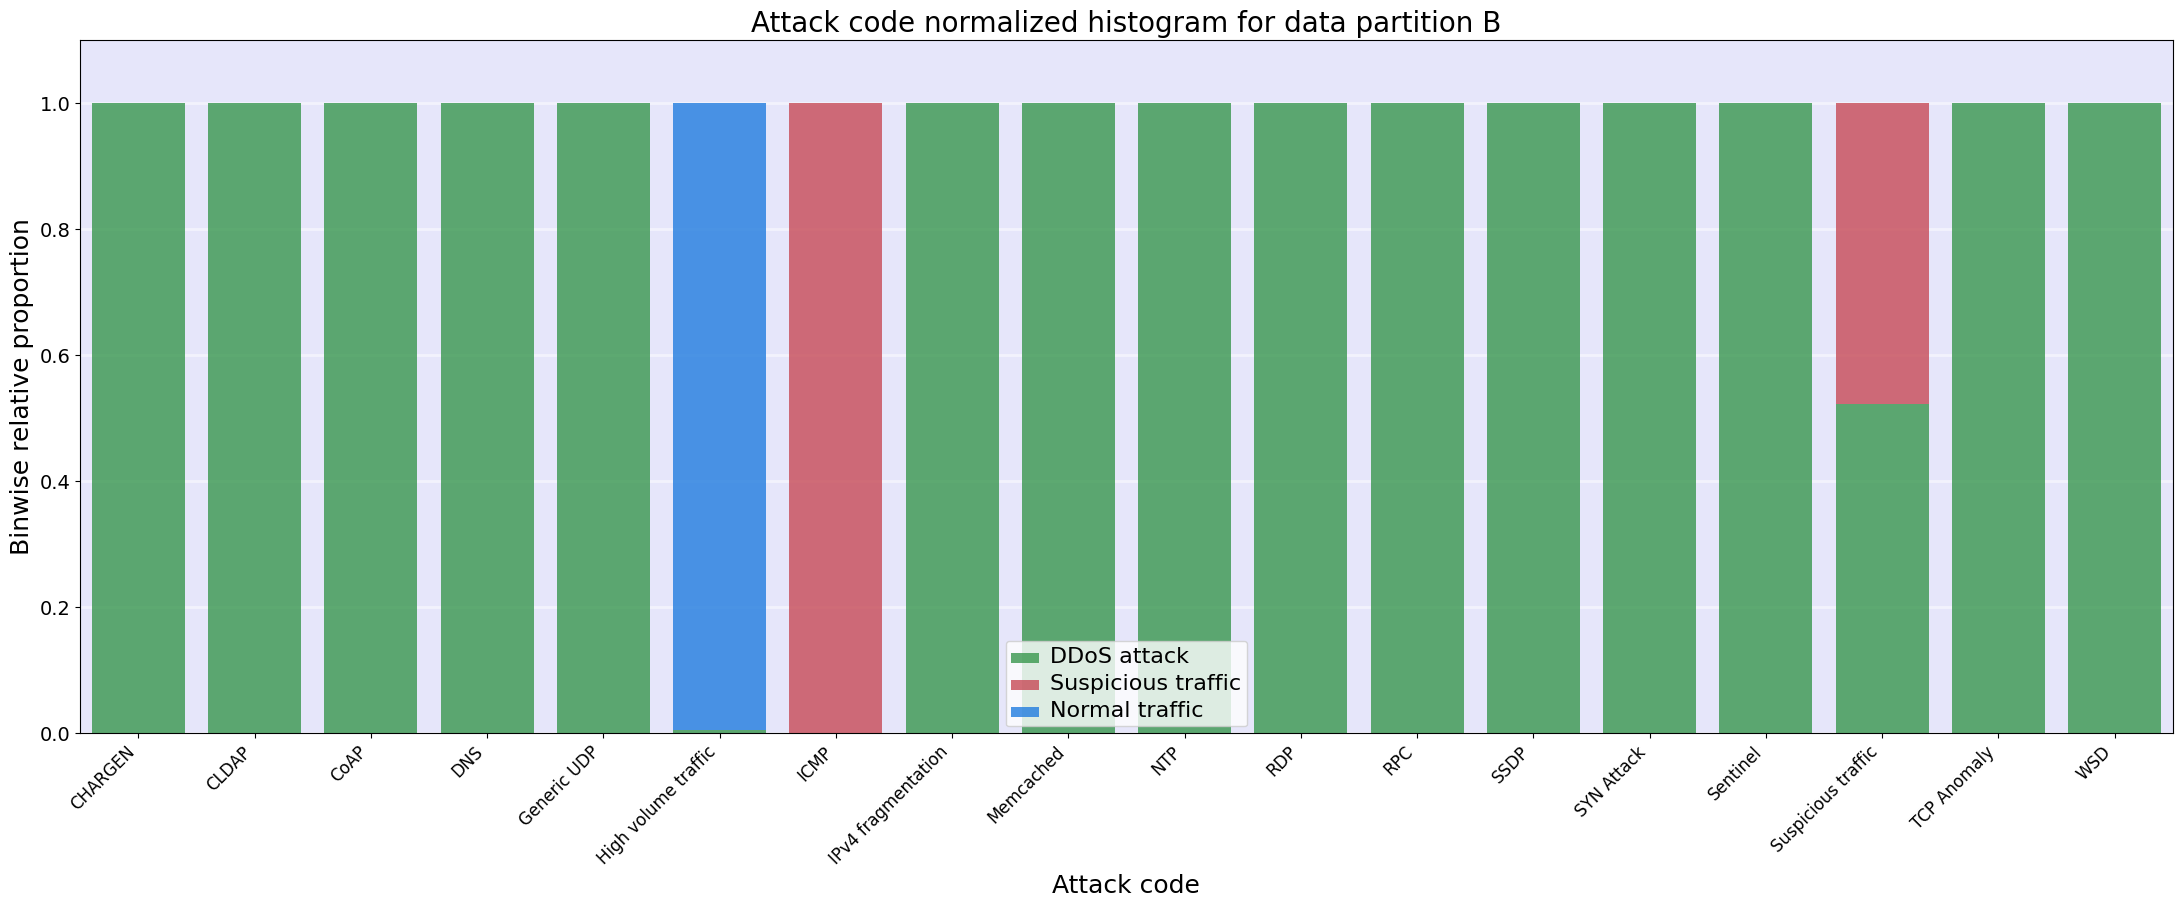

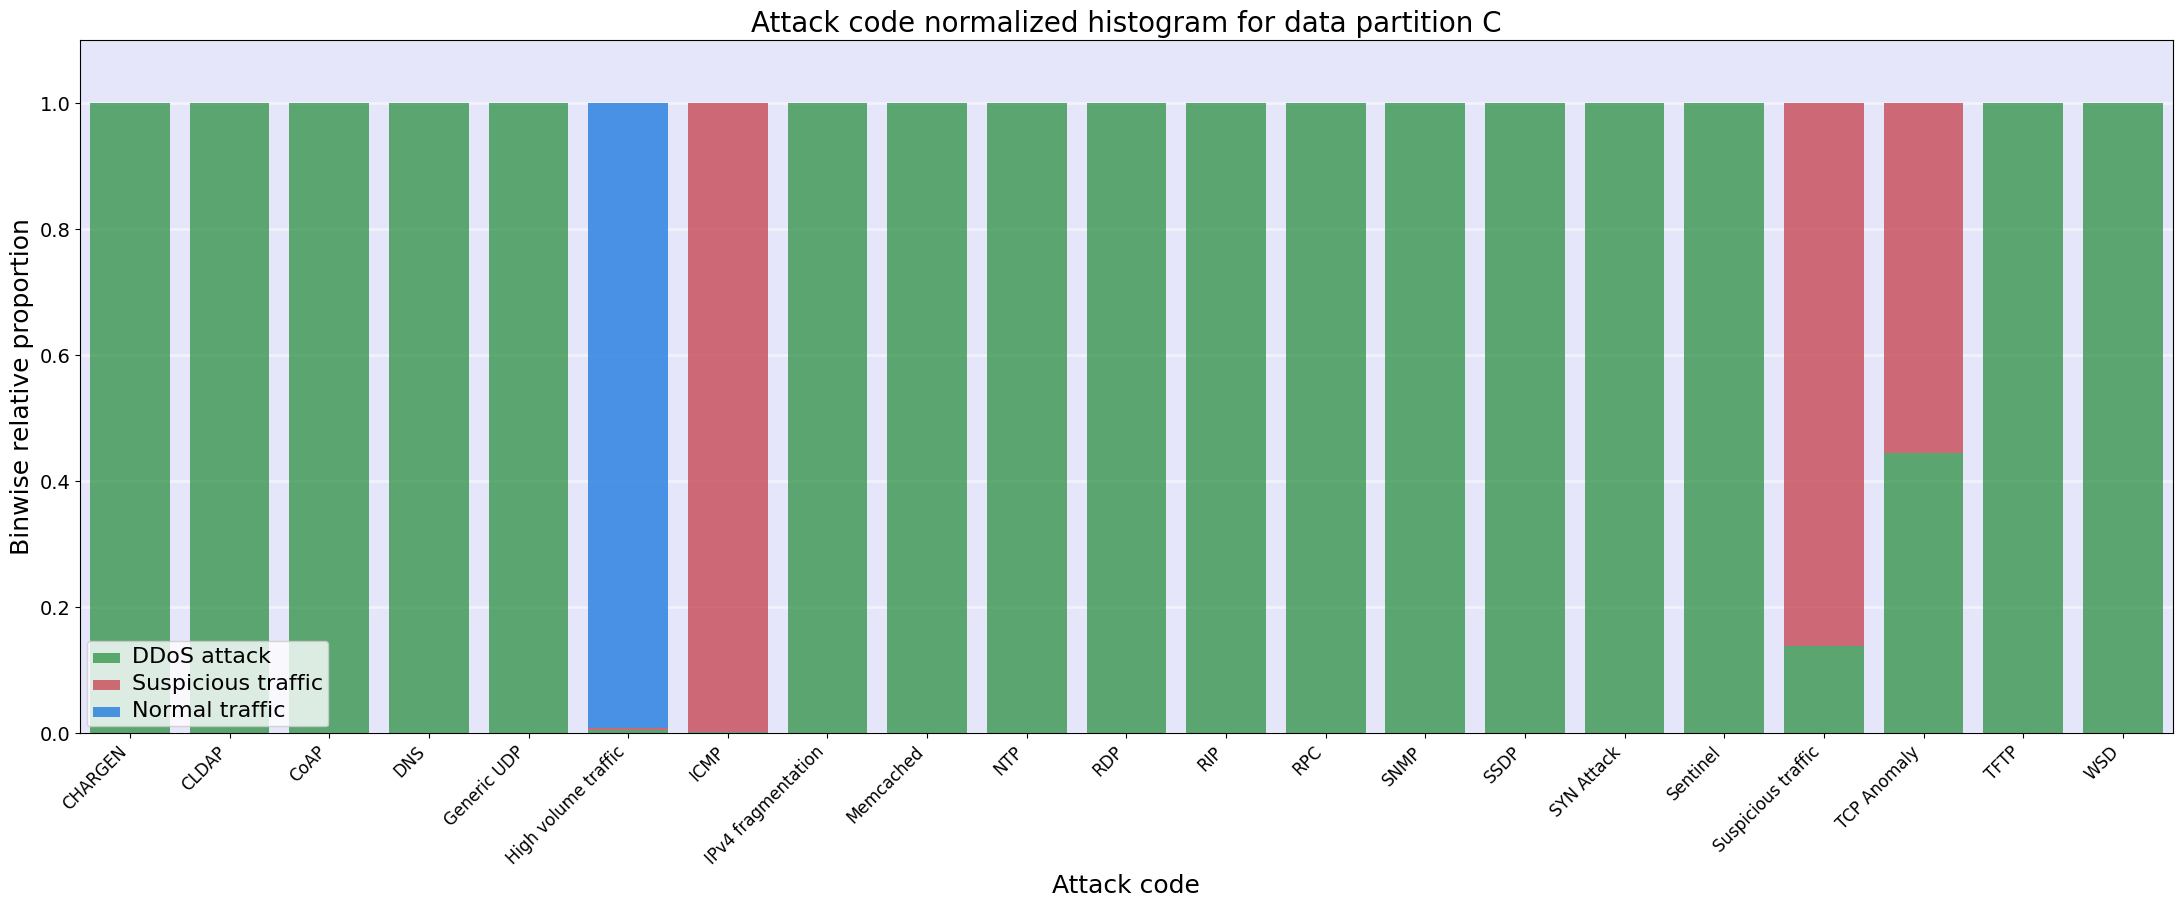

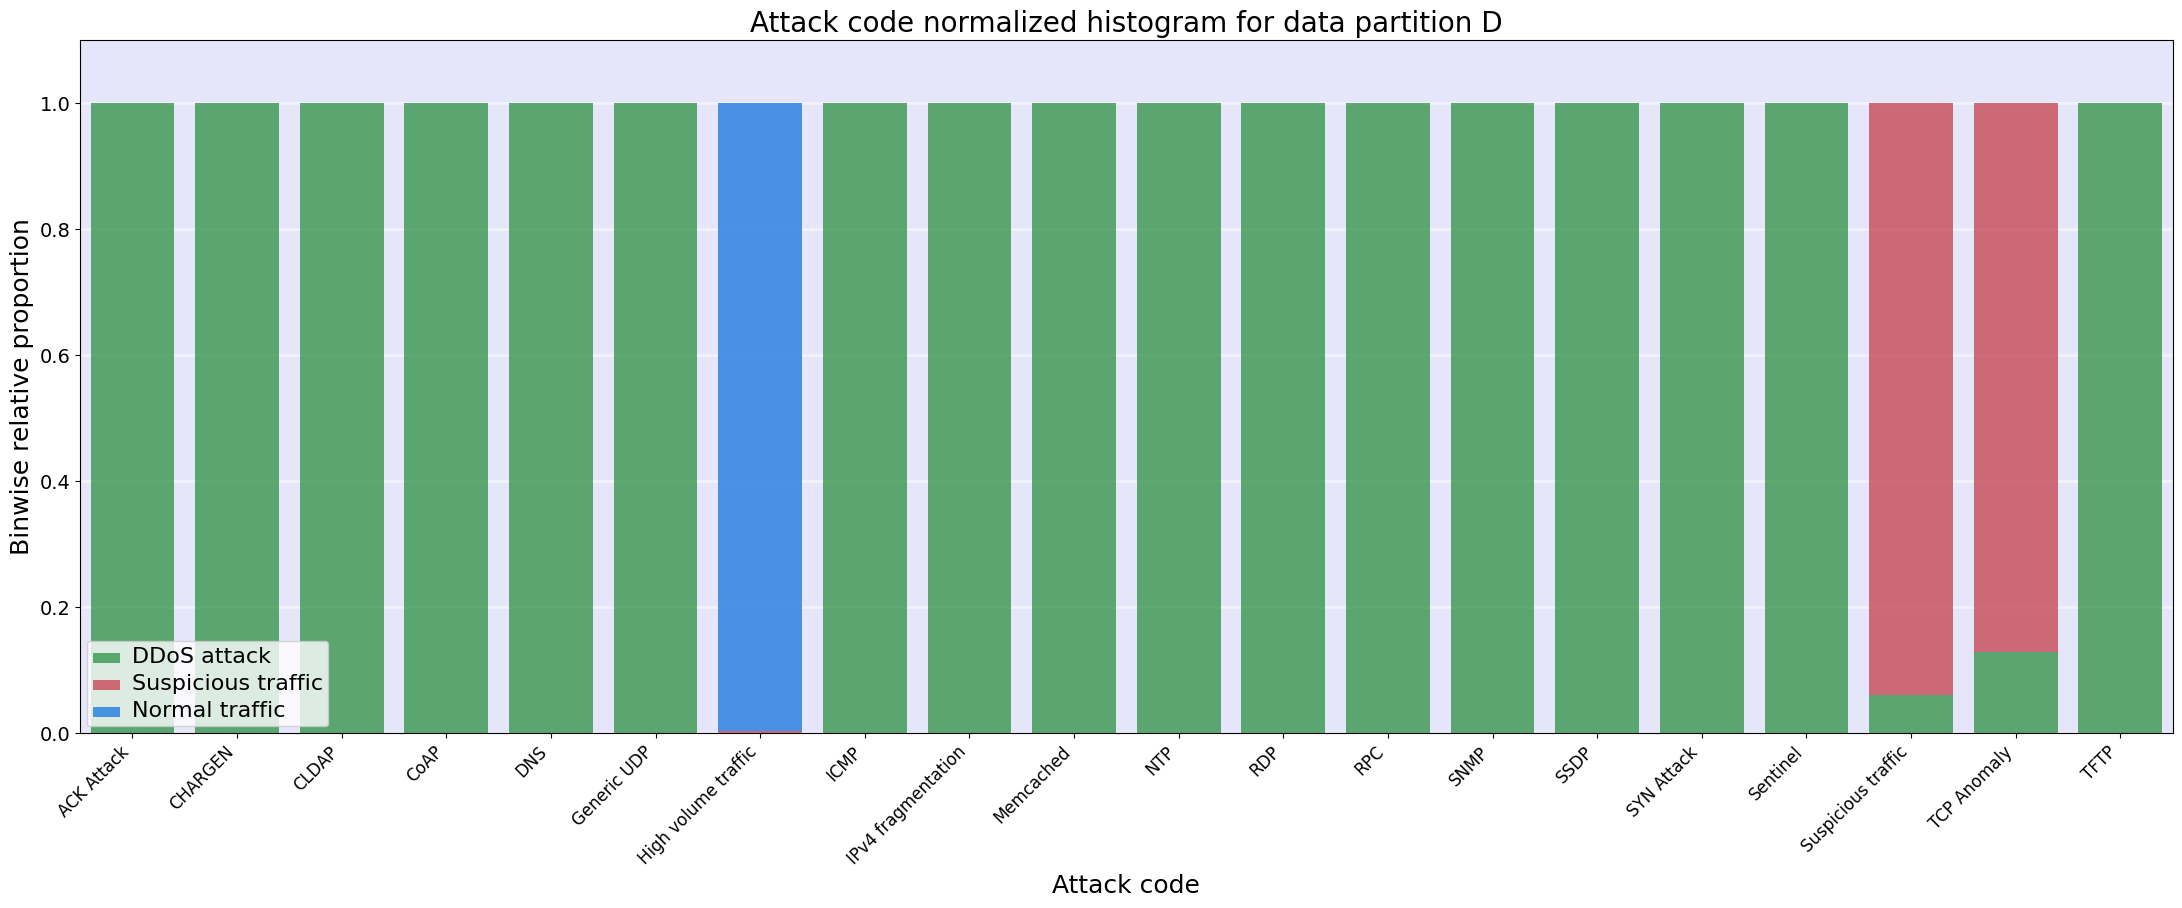

In [4]:
save_plots = False
fields = ['Avg source IP count', 'Data speed', 'Duration', 'Detect count']

partition_a = DataPartition('A')
partition_b = DataPartition('B')
partition_c = DataPartition('C')
partition_d = DataPartition('D')

for field in fields:
    partition_a.create_histogram_for_events(field, save=save_plots)
    partition_a.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_b.create_histogram_for_events(field, save=save_plots)
    partition_b.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_c.create_histogram_for_events(field, save=save_plots)
    partition_c.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_d.create_histogram_for_events(field, save=save_plots)
    partition_d.create_normalized_histogram_for_events(field=field, save=save_plots)

partition_a.create_normalized_histogram_for_attack_code(save=save_plots)
partition_b.create_normalized_histogram_for_attack_code(save=save_plots)
partition_c.create_normalized_histogram_for_attack_code(save=save_plots)
partition_d.create_normalized_histogram_for_attack_code(save=save_plots)